# Total dynamical O-information

## Index

1. [Functions](#functions)
1. [Load and binarize data](#load_binar_data)
1. [Full length](#full_length)
    1. [Thomas' work](#thomas_work_full)
    1. [3 vs 1-2](#3_vs_1-2_full)
        1. [J-S divergence](#J-S_divergence_full)
    1. [3 vs 1-1-1](#3_vs_1-1-1_full)
1. [Half length](#half_length)
    1. [Thomas' work](#thomas_work_half)
    1. [3 vs 1-2](#3_vs_1-2_half)
        1. [J-S divergence](#J-S_divergence_half)
    1. [3 vs 1-1-1](#3_vs_1-1-1_half)
1. [Comparison different lengths](#comparison_lengths)
    1. [Comparison full-half](#comparison_f_h)
    1. [Creation dataset](#creation_dataset)
        1. [Comparison Industrials](#comparison_industrials)
        1. [Comparison Basic Materials](#comparison_basic_materials)
        1. [Comparison Financials](#comparison_financials)
        1. [Comparison Consumer Services](#comparison_consumer_services)
        1. [Comparison Health Care](#comparison_health_care)
        1. [Comparison Utilities](#comparison_utilities)
        1. [Comparison Oil & Gas](#comparison_oil_gas)
        1. [Comparison Consumer Goods](#comparison_consumer_goods)
1. [Heatmaps](#heatmaps)
    1. [Matrix](#matrix)
    1. [Divided by year](#divided_year)
        1. [Same sector](#year_same_sector)
    1. [Divided by two years](#divided_two_years)
    1. [Divided by three years](#divided_three_years)
1. [O-information](#o_info)

<a name="functions"></a>
## Functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm.auto import tqdm
import matplotlib.patches as mpatches
import pickle
from scipy.special import kl_div
from scipy.stats import entropy

from ho_info_metrics.metrics import *
from ho_info_metrics.utils import *

In [2]:
def binarize_df(df, window_size):
    df = df.drop(columns=["Date"])
    for col in df.columns:
        if col != "Date":
            col_values = df[col].values
            binarized_values = []
            for i in range(len(col_values)):
                window_start = max(0, i - window_size + 1)
                window_mean = col_values[window_start : i + 1].mean()
                binarized_values.append(1 if col_values[i] > window_mean else 0)
            df[col] = binarized_values
    return df

In [3]:
def get_do_infos(target_sector, binarized_financial_ts):

    print(">>>", target_sector)
    target_stocks = list(
        stock_names[stock_names["Sector"] == target_sector]["Stock name"]
    )  # tutti gli stock name il cui settore sia il target
    print(len(target_stocks))
    other_stocks = list(
        stock_names[stock_names["Sector"] != target_sector]["Stock name"]
    )
    print(len(other_stocks))

    same_sector_triplets = list(combinations(target_stocks, 3))
    print(len(same_sector_triplets))
    different_sector_triplets = []
    while len(different_sector_triplets) != len(same_sector_triplets):
        triplet = []
        triplet.append(np.random.choice(target_stocks))
        triplet.append(np.random.choice(other_stocks))
        triplet.append(np.random.choice(other_stocks))
        different_sector_triplets.append(triplet)
    print(len(different_sector_triplets))

    doinfo_same_sector = []
    doinfo_different_sector = []
    bar_length = len(same_sector_triplets)
    with tqdm(total=bar_length) as pbar:
        pbar.set_description("Same sector triplets")
        for i in range(len(same_sector_triplets)):
            X1 = binarized_financial_ts[same_sector_triplets[i][0]].values
            X2 = binarized_financial_ts[same_sector_triplets[i][1]].values
            X3 = binarized_financial_ts[same_sector_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            doinfo_same_sector.append(
                o_information_lagged_all(X, estimator="cat_ent")
            )  # calcola la total dynamical o_information della tripletta
            pbar.update(1)

    bar_length = len(different_sector_triplets)
    with tqdm(total=bar_length) as pbar:
        for i in range(len(different_sector_triplets)):
            X1 = binarized_financial_ts[different_sector_triplets[i][0]].values
            X2 = binarized_financial_ts[different_sector_triplets[i][1]].values
            X3 = binarized_financial_ts[different_sector_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            doinfo_different_sector.append(
                o_information_lagged_all(X, estimator="cat_ent")
            )
            pbar.update(1)

    return (
        doinfo_same_sector,
        doinfo_different_sector,
    )  # ogni termine ritorna un array con la total dynamical o_information per ogni tripletta

In [4]:
def get_do_infos_same(target_sector, binarized_ts):
    """Get the total dynamical o_information for the triplets of the target sector"""

    print(">>>", target_sector)

    target_stocks = list(
        stock_names[stock_names["Sector"] == target_sector]["Stock name"]
    )  # tutti gli stock name il cui settore sia il target
    print("Length target_stocks:", len(target_stocks))

    # Having removed the Technology sector, each sector can now offer 35 triplets
    same_sector_triplets = list(combinations(target_stocks, 3))[:35]
    print("Length triplets same sector:", len(same_sector_triplets))

    doinfo_one_sector = []
    bar_length = len(same_sector_triplets)
    with tqdm(total=bar_length) as pbar:
        pbar.set_description("Same sector")
        for i in range(len(same_sector_triplets)):
            X1 = binarized_ts[same_sector_triplets[i][0]].values
            X2 = binarized_ts[same_sector_triplets[i][1]].values
            X3 = binarized_ts[same_sector_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            doinfo_one_sector.append(
                o_information_lagged_all(X, estimator="cat_ent")
            )  # calcola la total dynamical o_information della tripletta
            pbar.update(1)

    return doinfo_one_sector

In [5]:
def get_o_infos_same(target_sector, binarized_ts):
    """Get the O-information for the triplets of the target sector"""
    
    print(">>>", target_sector)

    target_stocks = list(
        stock_names[stock_names["Sector"] == target_sector]["Stock name"]
    )  # tutti gli stock name il cui settore sia il target
    print("Length target_stocks:", len(target_stocks))
    
    # Having removed the Technology sector, each sector can now offer 35 triplets
    same_sector_triplets = list(combinations(target_stocks, 3))[:35]
    print("Length triplets same sector:", len(same_sector_triplets))
    
    oinfo_one_sector = []
    bar_length = len(same_sector_triplets)
    with tqdm(total=bar_length) as pbar:
        pbar.set_description("Same sector")
        for i in range(len(same_sector_triplets)):
            X1 = binarized_ts[same_sector_triplets[i][0]].values
            X2 = binarized_ts[same_sector_triplets[i][1]].values
            X3 = binarized_ts[same_sector_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            oinfo_one_sector.append(
                o_information_boot(X, estimator="cat_ent")
            )  # calcola la O-information della tripletta
            pbar.update(1)

    return oinfo_one_sector

In [14]:
for sector in ["Industrials"]:
    oinfo_same_sector = get_o_infos_same(
        sector, binarized_financial_ts
    )
oinfo_same_sector

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

[0.0182732222113553,
 0.01534585555470347,
 0.02484042376235429,
 0.022427745194155024,
 0.025610769783172893,
 0.015694751354151215,
 0.02302495625520029,
 0.015918299916567014,
 0.012972001241772002,
 0.013649035721647662,
 0.009755287430738724,
 0.02649146121735524,
 0.020349302217513854,
 0.016898353993912263,
 0.023545284046101234,
 0.027225139162246226,
 0.015462954604164247,
 0.026933918840779114,
 0.021633636587431226,
 0.031194665614029837,
 0.02993952833604574,
 0.03307371562101857,
 0.02276507394468763,
 0.029583256479506215,
 0.0193513344000269,
 0.015754055696611147,
 0.01681406001339658,
 0.012391615307024706,
 0.03308948082332597,
 0.02828984217702013,
 0.024673177524459522,
 0.02692400152473251,
 0.02046395530409617,
 0.018889564919121637,
 0.033423073510750356]

In [15]:
def get_do_infos_two_different(target_sector, another_sector, binarized_ts):
    """Get the total dynamical o_information for the triplets
    composed of one node in the target_sector and two in the another_sector"""

    print(">>>", target_sector, "-", another_sector)

    target_stocks = list(
        stock_names[stock_names["Sector"] == target_sector]["Stock name"]
    )
    another_stocks = list(
        stock_names[stock_names["Sector"] == another_sector]["Stock name"]
    )
    print("Length another_stocks:", len(another_stocks))

    # Having removed the Technology sector, each sector can now offer 35 triplets
    another_sector_triplets = []
    while len(another_sector_triplets) != 35:
        triplet = []
        triplet.append(np.random.choice(target_stocks))
        triplet.append(np.random.choice(another_stocks))
        triplet.append(np.random.choice(another_stocks))
        another_sector_triplets.append(triplet)
    print("Length triplets two sectors:", len(another_sector_triplets))

    doinfo_two_sectors = []
    bar_length = len(another_sector_triplets)
    with tqdm(total=bar_length) as pbar:
        pbar.set_description("Two sectors")
        for i in range(len(another_sector_triplets)):
            X1 = binarized_ts[another_sector_triplets[i][0]].values
            X2 = binarized_ts[another_sector_triplets[i][1]].values
            X3 = binarized_ts[another_sector_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            doinfo_two_sectors.append(o_information_lagged_all(X, estimator="cat_ent"))
            pbar.update(1)

    return doinfo_two_sectors

In [16]:
def get_o_infos_two_different(target_sector, another_sector, binarized_ts):
    """Get the O-information for the triplets composed of one
    node in the target_sector and two in the another_sector"""

    print(">>>", target_sector, "-", another_sector)

    target_stocks = list(
        stock_names[stock_names["Sector"] == target_sector]["Stock name"]
    )
    another_stocks = list(
        stock_names[stock_names["Sector"] == another_sector]["Stock name"]
    )
    print("Length another_stocks:", len(another_stocks))

    # Having removed the Technology sector, each sector can now offer 35 triplets
    another_sector_triplets = []
    while len(another_sector_triplets) != 35:
        triplet = []
        triplet.append(np.random.choice(target_stocks))
        triplet.append(np.random.choice(another_stocks))
        triplet.append(np.random.choice(another_stocks))
        another_sector_triplets.append(triplet)
    print("Length triplets two sectors:", len(another_sector_triplets))

    oinfo_two_sectors = []
    bar_length = len(another_sector_triplets)
    with tqdm(total=bar_length) as pbar:
        pbar.set_description("Two sectors")
        for i in range(len(another_sector_triplets)):
            X1 = binarized_ts[another_sector_triplets[i][0]].values
            X2 = binarized_ts[another_sector_triplets[i][1]].values
            X3 = binarized_ts[another_sector_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            oinfo_two_sectors.append(o_information_boot(X, estimator="cat_ent"))
            pbar.update(1)

    return oinfo_two_sectors

In [17]:
def get_do_infos_three_different(
    target_sector, sector1, sector2, binarized_ts
):
    """Get the total dynamical o_information for the triplets
    composed of three nodes in three different sectors"""

    print(">>>", target_sector, "-", sector1, "-", sector2)

    target_stocks = list(
        stock_names[stock_names["Sector"] == target_sector]["Stock name"]
    )
    stocks1 = list(stock_names[stock_names["Sector"] == sector1]["Stock name"])
    print("Length sector1:", len(stocks1))
    stocks2 = list(stock_names[stock_names["Sector"] == sector2]["Stock name"])
    print("Length sector2:", len(stocks2))

    # Having removed the Technology sector, each sector can now offer 35 triplets
    three_sectors_triplets = []
    while len(three_sectors_triplets) != 35:
        triplet = []
        triplet.append(np.random.choice(target_stocks))
        triplet.append(np.random.choice(stocks1))
        triplet.append(np.random.choice(stocks2))
        three_sectors_triplets.append(triplet)
    print("Length triplets three sectors:", len(three_sectors_triplets))

    doinfo_three_sectors = []
    bar_length = len(three_sectors_triplets)
    with tqdm(total=bar_length) as pbar:
        pbar.set_description("Three sectors")
        for i in range(len(three_sectors_triplets)):
            X1 = binarized_ts[three_sectors_triplets[i][0]].values
            X2 = binarized_ts[three_sectors_triplets[i][1]].values
            X3 = binarized_ts[three_sectors_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            doinfo_three_sectors.append(
                o_information_lagged_all(X, estimator="cat_ent")
            )
            pbar.update(1)

    return doinfo_three_sectors

In [18]:
def get_o_infos_three_different(
    target_sector, sector1, sector2, binarized_ts
):
    """Get the O-information for the triplets
    composed of three nodes in three different sectors"""

    print(">>>", target_sector, "-", sector1, "-", sector2)

    target_stocks = list(
        stock_names[stock_names["Sector"] == target_sector]["Stock name"]
    )
    stocks1 = list(stock_names[stock_names["Sector"] == sector1]["Stock name"])
    print("Length sector1:", len(stocks1))
    stocks2 = list(stock_names[stock_names["Sector"] == sector2]["Stock name"])
    print("Length sector2:", len(stocks2))

    # Having removed the Technology sector, each sector can now offer 35 triplets
    three_sectors_triplets = []
    while len(three_sectors_triplets) != 35:
        triplet = []
        triplet.append(np.random.choice(target_stocks))
        triplet.append(np.random.choice(stocks1))
        triplet.append(np.random.choice(stocks2))
        three_sectors_triplets.append(triplet)
    print("Length triplets three sectors:", len(three_sectors_triplets))

    oinfo_three_sectors = []
    bar_length = len(three_sectors_triplets)
    with tqdm(total=bar_length) as pbar:
        pbar.set_description("Three sectors")
        for i in range(len(three_sectors_triplets)):
            X1 = binarized_ts[three_sectors_triplets[i][0]].values
            X2 = binarized_ts[three_sectors_triplets[i][1]].values
            X3 = binarized_ts[three_sectors_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            oinfo_three_sectors.append(
                o_information_boot(X, estimator="cat_ent")
            )
            pbar.update(1)

    return oinfo_three_sectors

In [19]:
def max_bins(array1, array2, array3):
    """Return the maximum number of bins so that there is at least one value inside each interval"""
    
    bins = 1
    cond = True

    while cond:
        bins += 1
        array1_hist, _ = np.histogram(array1, bins=bins)
        array2_hist, _ = np.histogram(array2, bins=bins)
        array3_hist, _ = np.histogram(array3, bins=bins)

        if np.isin(0, array1_hist):
            cond = False

        elif np.isin(0, array2_hist):
            cond = False

        elif np.isin(0, array3_hist):
            cond = False
            
    return bins - 1

In [20]:
def JS_div(array1, array2):
    """Compute the J-S divergence of two array"""
    
    array1_sort = np.sort(array1)
    array2_sort = np.sort(array2)

    array1_normalized = array1_sort / np.sum(array1_sort)
    array2_normalized = array2_sort / np.sum(array2_sort)

    average = (array1_normalized + array2_normalized) / 2
    average_sort = np.sort(average)
    
    bins = max_bins(array1_normalized, array2_normalized, average_sort)
    
    array1_hist, _ = np.histogram(array1_normalized, bins=bins)
    array2_hist, _ = np.histogram(array2_normalized, bins=bins)
    average_hist, _ = np.histogram(average_sort, bins=bins)
    
    kl_array1 = entropy(array1_hist, average_hist)
    kl_array2 = entropy(array2_hist, average_hist)
 
    return np.sum(kl_array1 + kl_array2) / 2

<a name="load_binar_data"></a>
## Load and binarize data

In [6]:
financial_ts = pd.read_csv(
    "data/Economic_data/NYSE_119stocks_2000Jan_2021June_withdates.csv"
)
stock_names = pd.read_csv(
    "data/Economic_data/list_stocknames.txt",
    sep=", ",
    names=["Index", "Stock name", "Sector"],
)

C:\Users\david\AppData\Local\Temp\ipykernel_11024\1982450507.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  stock_names = pd.read_csv(


In [7]:
financial_ts

,Date,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
0,1999-12-31 00:00:00,55.302216,99.724503,29.937500,3.796875,16.300713,14.250000,10.000000,32.125000,37.375000,...,3.805411,16.687500,28.855125,21.936281,8.3125,30.416479,19.500000,10.801292,15.187500,7.3750
1,2000-01-03 00:00:00,51.502148,97.246407,29.750000,3.890625,15.711531,13.937500,9.777778,31.437500,36.250000,...,3.650439,16.125000,29.471687,21.436594,8.3125,29.410976,19.000000,10.317096,15.125000,7.4375
2,2000-01-04 00:00:00,47.567955,97.696968,29.625000,3.625000,15.262630,13.562500,8.916667,31.812500,34.812500,...,3.512687,16.062500,31.198063,21.036844,8.5000,28.866327,18.875000,10.242604,15.000000,7.5000
3,2000-01-05 00:00:00,44.617310,103.329002,29.750000,3.906250,15.234574,13.312500,9.590278,33.000000,35.187500,...,3.564344,16.250000,32.492844,20.836969,8.8750,28.992016,18.937500,10.615063,14.843750,7.5625
4,2000-01-06 00:00:00,42.918453,101.977310,30.250000,4.203125,15.767643,13.562500,8.909722,33.187500,35.468750,...,3.374935,17.562500,31.198063,20.787001,9.0000,29.117704,19.375000,10.503325,14.500000,7.5625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,2021-06-11 00:00:00,143.529999,37.380001,45.900002,119.839996,109.910004,71.559998,34.320000,84.760002,25.879999,...,88.730003,92.830002,177.380005,47.619999,10.5400,151.759995,49.299999,139.110001,37.750000,8.1400
5396,2021-06-14 00:00:00,144.389999,36.950001,45.509998,118.730003,110.480003,72.169998,34.759998,85.129997,25.740000,...,87.980003,91.500000,178.179993,46.820000,10.6100,150.339996,49.500000,137.500000,37.880001,8.1600
5397,2021-06-15 00:00:00,144.619995,36.290001,45.349998,119.029999,110.410004,70.489998,34.209999,85.239998,26.059999,...,88.660004,90.940002,175.860001,46.779999,10.6100,151.369995,48.900002,136.710007,39.090000,8.1900
5398,2021-06-16 00:00:00,143.589996,35.360001,45.340000,118.360001,110.059998,70.320000,34.740002,84.400002,25.730000,...,87.330002,91.570000,174.660004,46.180000,10.5500,149.990005,48.119999,136.460007,39.720001,8.1500


In [8]:
stock_names

,Index,Stock name,Sector
0,0,A,Industrials
1,1,AA,Basic Materials
2,2,AB,Financials
3,3,ABC,Consumer Services
4,4,ABT,Health Care
...,...,...,...
114,114,DOV,Industrials
115,115,DRE,Financials
116,116,DRI,Consumer Services
117,117,DRQ,Oil & Gas


In [9]:
tw = 7  # time window, originalmente era 2
binarized_financial_ts = binarize_df(financial_ts, tw)

In [10]:
binarized_financial_ts

,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,AFG,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,0,1,0,1,0,0,1,1,0,0,...,0,0,1,0,1,0,0,1,0,1
4,0,1,1,1,1,0,0,1,0,0,...,0,1,1,0,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,1,0,1,1,1,0,1,0,1,0,...,0,0,1,1,1,1,1,1,1,0
5396,1,0,0,1,1,0,1,1,1,0,...,0,0,1,0,1,0,1,0,1,0
5397,1,0,0,1,1,0,1,1,1,1,...,0,0,0,0,1,1,0,0,1,1
5398,1,0,0,0,1,0,1,0,1,1,...,0,0,0,0,1,0,0,0,1,0


In [11]:
sectors = list(stock_names["Sector"].unique())
sectors

['Industrials',
 'Basic Materials',
 'Financials',
 'Consumer Services',
 'Health Care',
 'Utilities',
 'Oil & Gas',
 'Consumer Goods',
 'Technology']

<a name="full_length"></a>
## Full length

We consider the full length of the time series.

<a name="thomas_work_full"></a>
### Thomas' work

Each sector contains the maximun number of triplets, so the number of triplets is not constant.

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for i in range(len(sectors)):
    doinfo_same_sector, doinfo_different_sector = get_do_infos(
        sectors[i], binarized_financial_ts
    )

    np.save(
        f"./results/economic_results/full/do_info/doinfo_same_sector_{sectors[i]}_tw_{tw}.npy",
        doinfo_same_sector,
    )

    np.save(
        f"./results/economic_results/full/do_info/doinfo_different_sector_{sectors[i]}_tw_{tw}.npy",
        doinfo_different_sector,
    )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE VIOLIN PLOT

fig, axs = plt.subplots(3, 3, figsize=(40, 40))
for i in range(len(sectors)):
    row = i // 3
    col = i % 3
    doinfo_same_sector = np.load(
        f"./results/economic_results/full/do_info/doinfo_same_sector_{sectors[i]}_tw_{tw}.npy"
    )
    doinfo_different_sector = np.load(
        f"./results/economic_results/full/do_info/doinfo_different_sector_{sectors[i]}_tw_{tw}.npy"
    )
    parts = axs[row, col].violinplot(doinfo_same_sector, showextrema=False)
    for pc in parts["bodies"]:
        pc.set_facecolor("tab:blue")
        pc.set_edgecolor("black")
        pc.set_alpha(0.5)
    parts = axs[row, col].violinplot(doinfo_different_sector, showextrema=False)
    for pc in parts["bodies"]:
        pc.set_facecolor("tab:orange")
        pc.set_edgecolor("black")
        pc.set_alpha(0.5)
    axs[row, col].set_title(sectors[i], size=35)
    axs[row, col].set_ylabel(r"$d\Omega_3^{tot.}$", size=37)
    axs[row, col].tick_params(axis="both", labelsize=18)
    axs[row, col].legend(
        handles=[
            mpatches.Patch(color="tab:blue", label="Same sector", alpha=0.4),
            mpatches.Patch(color="tab:orange", label="Different sector", alpha=0.4),
        ],
        fontsize=30,
    )


plt.savefig(
    f"./results/economic_results/full/images/doinfo_random_sectors_tw_{tw}.pdf",
    dpi=600,
    bbox_inches="tight",
)

<a name="3_vs_1-2_full"></a>
### 3 vs 1-2

In previous work, a triplet from the same sector was compared with a triplet in which one node is from the target sector and the other two are randomly selected from other sectors. Now I would like to compare the triplet from the same sector with a more carefully chosen triplet (1 from the target sector and the other two from tho different chosen sectors).
  
To ensure that the number of triplets is always the same I take 35, which is the maximum number that all sectors can offer.

In [21]:
target_sector = "Technology"
list(stock_names[stock_names["Sector"] == target_sector]["Stock name"])

['CACI', 'CIEN', 'DBD', 'DDD']

In [22]:
# I am deleting the data for the Techonolgy sector because there are only a few
binarized_financial_ts = binarized_financial_ts.drop(
    columns=["CACI", "CIEN", "DBD", "DDD"]
)

In [23]:
# Usa il metodo .isin() per creare una maschera booleana
maschera = stock_names["Stock name"].isin(["CACI", "CIEN", "DBD", "DDD"])

# Usa la maschera per selezionare solo le righe che non soddisfano la condizione
stock_names = stock_names[~maschera]

In [24]:
sectors = sectors[:-1]
sectors

['Industrials',
 'Basic Materials',
 'Financials',
 'Consumer Services',
 'Health Care',
 'Utilities',
 'Oil & Gas',
 'Consumer Goods']

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]
    for i, sector in enumerate(other_sectors):

        if i == 0:
            doinfo_one_sector = get_do_infos_same(target, binarized_financial_ts)
            np.save(
                f"./results/economic_results/full/do_info/doinfo_one_sector_{target}_tw_{tw}.npy",
                doinfo_one_sector,
            )

        doinfo_two_sectors = get_do_infos_two_different(
            target, sector, binarized_financial_ts
        )
        np.save(
            f"./results/economic_results/full/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy",
            doinfo_two_sectors,
        )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE VIOLIN PLOTS

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]
    fig, axs = plt.subplots(3, 3, figsize=(40, 40))
    for i, sector in enumerate(other_sectors):
        row = i // 3
        col = i % 3
        doinfo_one_sector = np.load(
            f"./results/economic_results/full/do_info/doinfo_one_sector_{target}_tw_{tw}.npy"
        )
        doinfo_two_sectors = np.load(
            f"./results/economic_results/full/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy"
        )
        parts = axs[row, col].violinplot(doinfo_one_sector, showextrema=False)
        for pc in parts["bodies"]:
            pc.set_facecolor("tab:blue")
            pc.set_edgecolor("black")
            pc.set_alpha(0.5)
        parts = axs[row, col].violinplot(doinfo_two_sectors, showextrema=False)
        for pc in parts["bodies"]:
            pc.set_facecolor("tab:orange")
            pc.set_edgecolor("black")
            pc.set_alpha(0.5)
        title = str(target + " - " + sector)
        axs[row, col].set_title(title, size=35)
        axs[row, col].set_ylabel(r"$d\Omega_3^{tot.}$", size=40)
        axs[row, col].tick_params(axis="both", labelsize=18)
        label1 = str("3 in " + target)
        label2 = str("1 in " + target + ", 2 in " + sector)
        axs[row, col].legend(
            handles=[
                mpatches.Patch(color="tab:blue", label=label1, alpha=0.4),
                mpatches.Patch(color="tab:orange", label=label2, alpha=0.4),
            ],
            fontsize=25,
        )

    plt.savefig(
        f"./results/economic_results/full/images/two_sectors/doinfo_two_sectors_{target}_tw_{tw}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

<a name="J-S_divergence_full"></a>
#### J-S divergence

Let's summarize the difference between the two distributions into a single number, so we can make a comparison.

In [ ]:
# The row index indicates the target sector, the column index the other sector
df_full = pd.DataFrame(
    columns=[
        "Industrials",
        "Basic Materials",
        "Financials",
        "Consumer Services",
        "Health Care",
        "Utilities",
        "Oil & Gas",
        "Consumer Goods",
    ]
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]

    for i, sector in enumerate(other_sectors):
        doinfo_one_sector = np.load(
            f"./results/economic_results/full/do_info/doinfo_one_sector_{target}_tw_{tw}.npy"
        )
        doinfo_two_sectors = np.load(
            f"./results/economic_results/full/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy"
        )

        df_full.at[target, sector] = JS_div(doinfo_one_sector, doinfo_two_sectors)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

df_full.to_csv("./results/economic_results/full/result_full.csv", index=True)
df_full

<a name="3_vs_1-1-1_full"></a>
### 3 vs 1-1-1

The triplet from the same sector is compared with a triplet in which each element came from a different sector (one must be the target sector).
  
To ensure that the number of triplets is always the same I take 35, which is the maximum number that all sectors can offer.

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]

    for i, sector1 in enumerate(other_sectors):
        other_sectors2 = [sector for sector in other_sectors if sector != sector1]
        for j, sector2 in enumerate(other_sectors2):

            doinfo_three_sectors = get_do_infos_three_different(
                target, sector1, sector2, binarized_financial_ts
            )
            np.save(
                f"./results/economic_results/full/do_info/doinfo_three_sectors_{target}_{sector1}_{sector2}_tw_{tw}.npy",
                doinfo_three_sectors,
            )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE VIOLIN PLOTS

for target1 in sectors:
    for target2 in [sector for sector in sectors if sector != target1]:
        other_sectors = [
            sector for sector in sectors if sector != target1 and sector != target2
        ]

        fig, axs = plt.subplots(3, 2, figsize=(40, 40))
        for i, sector in enumerate(other_sectors):
            row = i // 2
            col = i % 2
            doinfo_one_sector = np.load(
                f"./results/economic_results/full/do_info/doinfo_one_sector_{target1}_tw_{tw}.npy"
            )
            doinfo_three_sectors = np.load(
                f"./results/economic_results/full/do_info/doinfo_three_sectors_{target1}_{target2}_{sector}_tw_{tw}.npy"
            )
            parts = axs[row, col].violinplot(doinfo_one_sector, showextrema=False)
            for pc in parts["bodies"]:
                pc.set_facecolor("tab:blue")
                pc.set_edgecolor("black")
                pc.set_alpha(0.5)
            parts = axs[row, col].violinplot(doinfo_three_sectors, showextrema=False)
            for pc in parts["bodies"]:
                pc.set_facecolor("tab:orange")
                pc.set_edgecolor("black")
                pc.set_alpha(0.5)
            title = str(target1 + " - " + target2 + " - " + sector)
            axs[row, col].set_title(title, size=40)
            axs[row, col].set_ylabel(r"$d\Omega_3^{tot.}$", size=45)
            axs[row, col].tick_params(axis="both", labelsize=25)
            label1 = str("3 in " + target1)
            label2 = str("1 in " + target1 + ", 1 in " + target2 + ", 1 in " + sector)
            axs[row, col].legend(
                handles=[
                    mpatches.Patch(color="tab:blue", label=label1, alpha=0.5),
                    mpatches.Patch(color="tab:orange", label=label2, alpha=0.5),
                ],
                fontsize=25,
            )

        plt.savefig(
            f"./results/economic_results/full/images/three_sectors/doinfo_three_sectors_{target1}_{target2}_tw_{tw}.pdf",
            dpi=600,
            bbox_inches="tight",
        )

<a name="half_length"></a>
## Half length

I only take half time series, to see if the differences between the distributions decrease.

In [ ]:
half_length = int(len(binarized_financial_ts) / 2)
binarized_financial_ts_half = binarized_financial_ts[:half_length]
binarized_financial_ts_half

<a name="thomas_work_half"></a>
### Thomas' work

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for i in range(len(sectors)):
    doinfo_same_sector, doinfo_different_sector = get_do_infos(
        sectors[i], binarized_financial_ts_half
    )

    np.save(
        f"./results/economic_results/half/do_info/doinfo_same_sector_{sectors[i]}_tw_{tw}.npy",
        doinfo_same_sector,
    )

    np.save(
        f"./results/economic_results/half/do_info/doinfo_different_sector_{sectors[i]}_tw_{tw}.npy",
        doinfo_different_sector,
    )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE VIOLIN PLOT

fig, axs = plt.subplots(3, 3, figsize=(40, 40))
for i in range(len(sectors)):
    row = i // 3
    col = i % 3
    doinfo_same_sector = np.load(
        f"./results/economic_results/half/do_info/doinfo_same_sector_{sectors[i]}_tw_{tw}.npy"
    )
    doinfo_different_sector = np.load(
        f"./results/economic_results/half/do_info/doinfo_different_sector_{sectors[i]}_tw_{tw}.npy"
    )
    parts = axs[row, col].violinplot(doinfo_same_sector, showextrema=False)
    for pc in parts["bodies"]:
        pc.set_facecolor("tab:blue")
        pc.set_edgecolor("black")
        pc.set_alpha(0.5)
    parts = axs[row, col].violinplot(doinfo_different_sector, showextrema=False)
    for pc in parts["bodies"]:
        pc.set_facecolor("tab:orange")
        pc.set_edgecolor("black")
        pc.set_alpha(0.5)
    axs[row, col].set_title(sectors[i], size=35)
    axs[row, col].set_ylabel(r"$d\Omega_3^{tot.}$", size=37)
    axs[row, col].tick_params(axis="both", labelsize=18)
    axs[row, col].legend(
        handles=[
            mpatches.Patch(color="tab:blue", label="Same sector", alpha=0.4),
            mpatches.Patch(color="tab:orange", label="Different sector", alpha=0.4),
        ],
        fontsize=30,
    )


plt.savefig(
    f"./results/economic_results/half/images/doinfo_random_sectors_tw_{tw}.pdf",
    dpi=600,
    bbox_inches="tight",
)

<a name="3_vs_1-2_half"></a>
### 3 vs 1-2

!!!! Run the initial part of the full 3 vs 1-2 first, so as to eliminate the stocks relating to technology

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]
    for i, sector in enumerate(other_sectors):

        if i == 0:
            doinfo_one_sector = get_do_infos_same(target, binarized_financial_ts_half)
            np.save(
                f"./results/economic_results/half/do_info/doinfo_one_sector_{target}_tw_{tw}.npy",
                doinfo_one_sector,
            )

        doinfo_two_sectors = get_do_infos_two_different(
            target, sector, binarized_financial_ts_half
        )
        np.save(
            f"./results/economic_results/half/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy",
            doinfo_two_sectors,
        )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE VIOLIN PLOTS

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]
    fig, axs = plt.subplots(3, 3, figsize=(40, 40))
    for i, sector in enumerate(other_sectors):
        row = i // 3
        col = i % 3
        doinfo_one_sector = np.load(
            f"./results/economic_results/half/do_info/doinfo_one_sector_{target}_tw_{tw}.npy"
        )
        doinfo_two_sectors = np.load(
            f"./results/economic_results/half/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy"
        )
        parts = axs[row, col].violinplot(doinfo_one_sector, showextrema=False)
        for pc in parts["bodies"]:
            pc.set_facecolor("tab:blue")
            pc.set_edgecolor("black")
            pc.set_alpha(0.5)
        parts = axs[row, col].violinplot(doinfo_two_sectors, showextrema=False)
        for pc in parts["bodies"]:
            pc.set_facecolor("tab:orange")
            pc.set_edgecolor("black")
            pc.set_alpha(0.5)
        title = str(target + " - " + sector)
        axs[row, col].set_title(title, size=35)
        axs[row, col].set_ylabel(r"$d\Omega_3^{tot.}$", size=40)
        axs[row, col].tick_params(axis="both", labelsize=18)
        label1 = str("3 in " + target)
        label2 = str("1 in " + target + ", 2 in " + sector)
        axs[row, col].legend(
            handles=[
                mpatches.Patch(color="tab:blue", label=label1, alpha=0.4),
                mpatches.Patch(color="tab:orange", label=label2, alpha=0.4),
            ],
            fontsize=25,
        )

    plt.savefig(
        f"./results/economic_results/half/images/two_sectors/doinfo_two_sectors_{target}_tw_{tw}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

<a name="J-S_divergence_half"></a>
#### J-S divergence

In [ ]:
# The row index indicates the target sector, the column index the other sector
df_half = pd.DataFrame(
    columns=[
        "Industrials",
        "Basic Materials",
        "Financials",
        "Consumer Services",
        "Health Care",
        "Utilities",
        "Oil & Gas",
        "Consumer Goods",
    ]
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]

    for i, sector in enumerate(other_sectors):
        doinfo_one_sector = np.load(
            f"./results/economic_results/half/do_info/doinfo_one_sector_{target}_tw_{tw}.npy"
        )
        doinfo_two_sectors = np.load(
            f"./results/economic_results/half/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy"
        )

        df_half.at[target, sector] = JS_div(doinfo_one_sector, doinfo_two_sectors)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

df_half.to_csv("./results/economic_results/half/result_full.csv", index=True)
df_half

<a name="3_vs_1-1-1_half"></a>
### 3 vs 1-1-1

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]

    for i, sector1 in enumerate(other_sectors):
        other_sectors2 = [sector for sector in other_sectors if sector != sector1]
        for j, sector2 in enumerate(other_sectors2):

            doinfo_three_sectors = get_do_infos_three_different(
                target, sector1, sector2, binarized_financial_ts_half
            )
            np.save(
                f"./results/economic_results/half/do_info/doinfo_three_sectors_{target}_{sector1}_{sector2}_tw_{tw}.npy",
                doinfo_three_sectors,
            )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE VIOLIN PLOTS

for target1 in sectors:
    for target2 in [sector for sector in sectors if sector != target1]:
        other_sectors = [
            sector for sector in sectors if sector != target1 and sector != target2
        ]

        fig, axs = plt.subplots(3, 2, figsize=(40, 40))
        for i, sector in enumerate(other_sectors):
            row = i // 2
            col = i % 2
            doinfo_one_sector = np.load(
                f"./results/economic_results/half/do_info/doinfo_one_sector_{target1}_tw_{tw}.npy"
            )
            doinfo_three_sectors = np.load(
                f"./results/economic_results/half/do_info/doinfo_three_sectors_{target1}_{target2}_{sector}_tw_{tw}.npy"
            )
            parts = axs[row, col].violinplot(doinfo_one_sector, showextrema=False)
            for pc in parts["bodies"]:
                pc.set_facecolor("tab:blue")
                pc.set_edgecolor("black")
                pc.set_alpha(0.5)
            parts = axs[row, col].violinplot(doinfo_three_sectors, showextrema=False)
            for pc in parts["bodies"]:
                pc.set_facecolor("tab:orange")
                pc.set_edgecolor("black")
                pc.set_alpha(0.5)
            title = str(target1 + " - " + target2 + " - " + sector)
            axs[row, col].set_title(title, size=40)
            axs[row, col].set_ylabel(r"$d\Omega_3^{tot.}$", size=45)
            axs[row, col].tick_params(axis="both", labelsize=25)
            label1 = str("3 in " + target1)
            label2 = str("1 in " + target1 + ", 1 in " + target2 + ", 1 in " + sector)
            axs[row, col].legend(
                handles=[
                    mpatches.Patch(color="tab:blue", label=label1, alpha=0.5),
                    mpatches.Patch(color="tab:orange", label=label2, alpha=0.5),
                ],
                fontsize=25,
            )

        plt.savefig(
            f"./results/economic_results/half/images/three_sectors/doinfo_three_sectors_{target1}_{target2}_tw_{tw}.pdf",
            dpi=600,
            bbox_inches="tight",
        )

<a name="comparison_lengths"></a>
## Comparison different lengths

<a name="comparison_f_h"></a>
### Comparison full-half

In this section I compare the results obtained considering the entire length with those obtained considering only half of it. In each plot a target is considered; on the y-axis there is the JS-divergence (for full length) between the distributions in which the triplet is all in the target and in which one point is in the target and the other two in another sector. On the x axis there is the similar quantity but for half the length.

In [ ]:
df_full = pd.read_csv("./results/economic_results/full/result_full.csv", index_col=0)
df_half = pd.read_csv("./results/economic_results/half/result_full.csv", index_col=0)

In [ ]:
df_full

In [ ]:
df_half

In [ ]:
name_rows = df_full.index.tolist()
name_columns = df_full.columns.tolist()

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE SCATTER PLOTS

for row in name_rows:
    columns = [column for column in name_columns if column != row]

    x = [df_half.loc[row, column] for column in columns]
    y = [df_full.loc[row, column] for column in columns]
    
    x_values = np.linspace(min(x), max(x), 100)
    plt.plot(x_values, x_values, color="red", linewidth=1.5)

    plt.scatter(x, y)
    plt.xlabel("JS-div half length")
    plt.ylabel("JS-div full length")
    plt.title(f"Plot for target = {row}")
    plt.savefig(
        f"./results/economic_results/comparison/images/JS_div_two_sectors_target_{row}.pdf",
        dpi=600,
        bbox_inches="tight",
    )
    plt.show()

In [ ]:
above_bisector = []
below_bisector = []

for row in name_rows:
    above_count = 0
    columns = [column for column in name_columns if column != row]

    x = [df_half.loc[row, column] for column in columns]
    y = [df_full.loc[row, column] for column in columns]
    
    for i in range(len(x)):
        if x[i] < y[i]:
            above_count += 1
            
    above_bisector.append(above_count)
    below_bisector.append(len(x) - above_count)
    

df_comparison = pd.DataFrame(
    [above_bisector, below_bisector], index=["+", "-"], columns=name_columns
)

df_comparison

<a name="creation_dataset"></a>
### Creation dataset

I consider the performance of the JS-div as the length of the TS varies.

Full length

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

length = len(binarized_financial_ts)

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]

    for i, sector in enumerate(other_sectors):
        doinfo_one_sector = np.load(
            f"./results/economic_results/full/do_info/doinfo_one_sector_{target}_tw_{tw}.npy"
        )
        np.save(
            f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy",
            doinfo_one_sector,
        )

        doinfo_two_sectors = np.load(
            f"./results/economic_results/full/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy"
        )
        np.save(
            f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy",
            doinfo_two_sectors,
        )

Half length

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

length = int(len(binarized_financial_ts) / 2)

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]

    for i, sector in enumerate(other_sectors):
        doinfo_one_sector = np.load(
            f"./results/economic_results/half/do_info/doinfo_one_sector_{target}_tw_{tw}.npy"
        )
        np.save(
            f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy",
            doinfo_one_sector,
        )

        doinfo_two_sectors = np.load(
            f"./results/economic_results/half/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy"
        )
        np.save(
            f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy",
            doinfo_two_sectors,
        )

Other lengths

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

lengths = [540, 1080, 1620, 2160, 3240, 3780, 4320, 4860]

for length in lengths:
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for i, sector in enumerate(other_sectors):

            if i == 0:
                doinfo_one_sector = get_do_infos_same(
                    target, binarized_financial_ts[:length]
                )
                np.save(
                    f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy",
                    doinfo_one_sector,
                )

            doinfo_two_sectors = get_do_infos_two_different(
                target, sector, binarized_financial_ts[:length]
            )
            np.save(
                f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy",
                doinfo_two_sectors,
            )

<a name="comparison_industrials"></a>
#### Comparison Industrials

In [ ]:
df_industrials = pd.DataFrame(
    columns=[
        "Basic Materials",
        "Financials",
        "Consumer Services",
        "Health Care",
        "Utilities",
        "Oil & Gas",
        "Consumer Goods",
    ]
)

In [ ]:
lengths = [
    int(len(binarized_financial_ts) * i)
    for i in np.linspace(0.1, 1, 10)
]

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for length in lengths:
    for target in ["Industrials"]:
        other_sectors = [sector for sector in sectors if sector != target]

        for i, sector in enumerate(other_sectors):
            doinfo_one_sector = np.load(
                f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy"
            )
            doinfo_two_sectors = np.load(
                f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy"
            )

            df_industrials.at[length, sector] = JS_div(doinfo_one_sector, doinfo_two_sectors)
            
df_industrials.to_csv("./results/economic_results/comparison/length_Industrials.csv", index=True)

In [ ]:
df_industrials = pd.read_csv("./results/economic_results/comparison/length_Industrials.csv", index_col=0)
df_industrials

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE PLOT

num_rows = len(df_industrials.columns)
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 25))

for i, column in enumerate(df_industrials.columns):
    label = str(f"{column}")
    axs[i].scatter(df_industrials.index, df_industrials[column], label=label)

    axs[i].legend(fontsize=13)
    axs[i].set_ylabel("JS-div", fontsize=14)

    if i == num_rows - 1:
        axs[i].set_xlabel("Length", fontsize=14)

fig.suptitle("Industrials", fontsize=22)
plt.subplots_adjust(top=0.96)

plt.savefig(
    f"./results/economic_results/comparison/images/JS_div_different_lengths_Industrials.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="comparison_basic_materials"></a>
#### Comparison Basic Materials

In [ ]:
df__basic_materials = pd.DataFrame(
    columns=[
        "Industrials",
        "Financials",
        "Consumer Services",
        "Health Care",
        "Utilities",
        "Oil & Gas",
        "Consumer Goods",
    ]
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for length in lengths:
    for target in ["Basic Materials"]:
        other_sectors = [sector for sector in sectors if sector != target]

        for i, sector in enumerate(other_sectors):
            doinfo_one_sector = np.load(
                f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy"
            )
            doinfo_two_sectors = np.load(
                f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy"
            )

            df__basic_materials.at[length, sector] = JS_div(doinfo_one_sector, doinfo_two_sectors)
            
df__basic_materials.to_csv("./results/economic_results/comparison/length_Basic_Materials.csv", index=True)

In [ ]:
df__basic_materials = pd.read_csv("./results/economic_results/comparison/length_Basic_Materials.csv", index_col=0)
df__basic_materials

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE PLOT

num_rows = len(df__basic_materials.columns)
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 25))

for i, column in enumerate(df__basic_materials.columns):
    label = str(f"{column}")
    axs[i].scatter(df__basic_materials.index, df__basic_materials[column], label=label)

    axs[i].legend(fontsize=13)
    axs[i].set_ylabel("JS-div", fontsize=14)

    if i == num_rows - 1:
        axs[i].set_xlabel("Length", fontsize=14)

fig.suptitle("Basic Materials", fontsize=22)
plt.subplots_adjust(top=0.96)

plt.savefig(
    f"./results/economic_results/comparison/images/JS_div_different_lengths_Basic_Materials.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="comparison_financials"></a>
#### Comparison Financials

In [ ]:
df_financials = pd.DataFrame(
    columns=[
        "Industrials",
        "Basic Materials",
        "Consumer Services",
        "Health Care",
        "Utilities",
        "Oil & Gas",
        "Consumer Goods",
    ]
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for length in lengths:
    for target in ["Financials"]:
        other_sectors = [sector for sector in sectors if sector != target]

        for i, sector in enumerate(other_sectors):
            doinfo_one_sector = np.load(
                f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy"
            )
            doinfo_two_sectors = np.load(
                f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy"
            )

            df_financials.at[length, sector] = JS_div(doinfo_one_sector, doinfo_two_sectors)

df_financials.to_csv("./results/economic_results/comparison/length_Financial.csv", index=True)

In [ ]:
df_financials = pd.read_csv("./results/economic_results/comparison/length_Financial.csv", index_col=0)
df_financials

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE PLOT

num_rows = len(df_financials.columns)
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 25))

for i, column in enumerate(df_financials.columns):
    label = str(f"{column}")
    axs[i].scatter(df_financials.index, df_financials[column], label=label)

    axs[i].legend(fontsize=13)
    axs[i].set_ylabel("JS-div", fontsize=14)

    if i == num_rows - 1:
        axs[i].set_xlabel("Length", fontsize=14)

fig.suptitle("Financials", fontsize=22)
plt.subplots_adjust(top=0.96)

plt.savefig(
    f"./results/economic_results/comparison/images/JS_div_different_lengths_Financials.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="comparison_consumer_services"></a>
#### Comparison Consumer Services

In [ ]:
df_consumer_services = pd.DataFrame(
    columns=[
        "Industrials",
        "Basic Materials",
        "Financials",
        "Health Care",
        "Utilities",
        "Oil & Gas",
        "Consumer Goods",
    ]
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for length in lengths:
    for target in ["Consumer Services"]:
        other_sectors = [sector for sector in sectors if sector != target]

        for i, sector in enumerate(other_sectors):
            doinfo_one_sector = np.load(
                f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy"
            )
            doinfo_two_sectors = np.load(
                f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy"
            )

            df_consumer_services.at[length, sector] = JS_div(doinfo_one_sector, doinfo_two_sectors)
            
df_consumer_services.to_csv("./results/economic_results/comparison/length_Consumer_Services.csv", index=True)

In [ ]:
df_consumer_services = pd.read_csv("./results/economic_results/comparison/length_Consumer_Services.csv", index_col=0)
df_consumer_services

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE PLOT

num_rows = len(df_consumer_services.columns)
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 25))

for i, column in enumerate(df_consumer_services.columns):
    label = str(f"{column}")
    axs[i].scatter(df_consumer_services.index, df_consumer_services[column], label=label)

    axs[i].legend(fontsize=13)
    axs[i].set_ylabel("JS-div", fontsize=14)

    if i == num_rows - 1:
        axs[i].set_xlabel("Length", fontsize=14)

fig.suptitle("Consumer Services", fontsize=22)
plt.subplots_adjust(top=0.96)

plt.savefig(
    f"./results/economic_results/comparison/images/JS_div_different_lengths_Consumer_Services.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="comparison_health_care"></a>
#### Comparison Health Care

In [ ]:
df_health_care = pd.DataFrame(
    columns=[
        "Industrials",
        "Basic Materials",
        "Financials",
        "Consumer Services",
        "Utilities",
        "Oil & Gas",
        "Consumer Goods",
    ]
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for length in lengths:
    for target in ["Health Care"]:
        other_sectors = [sector for sector in sectors if sector != target]

        for i, sector in enumerate(other_sectors):
            doinfo_one_sector = np.load(
                f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy"
            )
            doinfo_two_sectors = np.load(
                f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy"
            )

            df_health_care.at[length, sector] = JS_div(doinfo_one_sector, doinfo_two_sectors)
            
df_health_care.to_csv("./results/economic_results/comparison/length_Health_Care.csv", index=True)

In [ ]:
df_health_care = pd.read_csv("./results/economic_results/comparison/length_Health_Care.csv", index_col=0)
df_health_care

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE PLOT

num_rows = len(df_health_care.columns)
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 25))

for i, column in enumerate(df_health_care.columns):
    label = str(f"{column}")
    axs[i].scatter(df_health_care.index, df_health_care[column], label=label)

    axs[i].legend(fontsize=13)
    axs[i].set_ylabel("JS-div", fontsize=14)

    if i == num_rows - 1:
        axs[i].set_xlabel("Length", fontsize=14)

fig.suptitle("Health Care", fontsize=22)
plt.subplots_adjust(top=0.96)

plt.savefig(
    f"./results/economic_results/comparison/images/JS_div_different_lengths_Health_Care.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="comparison_utilities"></a>
#### Comparison Utilities

In [ ]:
df_utilities = pd.DataFrame(
    columns=[
        "Industrials",
        "Basic Materials",
        "Financials",
        "Consumer Services",
        "Health Care",
        "Oil & Gas",
        "Consumer Goods",
    ]
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for length in lengths:
    for target in ["Utilities"]:
        other_sectors = [sector for sector in sectors if sector != target]

        for i, sector in enumerate(other_sectors):
            doinfo_one_sector = np.load(
                f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy"
            )
            doinfo_two_sectors = np.load(
                f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy"
            )

            df_utilities.at[length, sector] = JS_div(doinfo_one_sector, doinfo_two_sectors)
            
df_utilities.to_csv("./results/economic_results/comparison/length_Utilities.csv", index=True)

In [ ]:
df_utilities = pd.read_csv("./results/economic_results/comparison/length_Utilities.csv", index_col=0)
df_utilities

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE PLOT

num_rows = len(df_utilities.columns)
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 25))

for i, column in enumerate(df_utilities.columns):
    label = str(f"{column}")
    axs[i].scatter(df_utilities.index, df_utilities[column], label=label)

    axs[i].legend(fontsize=13)
    axs[i].set_ylabel("JS-div", fontsize=14)

    if i == num_rows - 1:
        axs[i].set_xlabel("Length", fontsize=14)

fig.suptitle("Utilities", fontsize=22)
plt.subplots_adjust(top=0.96)

plt.savefig(
    f"./results/economic_results/comparison/images/JS_div_different_lengths_Utilities.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="comparison_oil_gas"></a>
#### Comparison Oil & Gas

In [ ]:
df_oil_gas = pd.DataFrame(
    columns=[
        "Industrials",
        "Basic Materials",
        "Financials",
        "Consumer Services",
        "Health Care",
        "Utilities",
        "Consumer Goods",
    ]
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for length in lengths:
    for target in ["Oil & Gas"]:
        other_sectors = [sector for sector in sectors if sector != target]

        for i, sector in enumerate(other_sectors):
            doinfo_one_sector = np.load(
                f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy"
            )
            doinfo_two_sectors = np.load(
                f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy"
            )

            df_oil_gas.at[length, sector] = JS_div(doinfo_one_sector, doinfo_two_sectors)
            
df_oil_gas.to_csv("./results/economic_results/comparison/length_Oil_Gas.csv", index=True)

In [ ]:
df_oil_gas = pd.read_csv("./results/economic_results/comparison/length_Oil_Gas.csv", index_col=0)
df_oil_gas

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE PLOT

num_rows = len(df_oil_gas.columns)
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 25))

for i, column in enumerate(df_oil_gas.columns):
    label = str(f"{column}")
    axs[i].scatter(df_oil_gas.index, df_oil_gas[column], label=label)

    axs[i].legend(fontsize=13)
    axs[i].set_ylabel("JS-div", fontsize=14)

    if i == num_rows - 1:
        axs[i].set_xlabel("Length", fontsize=14)

fig.suptitle("Oil & Gas", fontsize=22)
plt.subplots_adjust(top=0.96)

plt.savefig(
    f"./results/economic_results/comparison/images/JS_div_different_lengths_Oil_Gas.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="comparison_consumer_goods"></a>
#### Comparison Consumer Goods

In [ ]:
df_consumer_goods = pd.DataFrame(
    columns=[
        "Industrials",
        "Basic Materials",
        "Financials",
        "Consumer Services",
        "Health Care",
        "Utilities",
        "Oil & Gas",
    ]
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for length in lengths:
    for target in ["Consumer Goods"]:
        other_sectors = [sector for sector in sectors if sector != target]

        for i, sector in enumerate(other_sectors):
            doinfo_one_sector = np.load(
                f"./results/economic_results/comparison/do_info/one_sector_{target}_length_{length}.npy"
            )
            doinfo_two_sectors = np.load(
                f"./results/economic_results/comparison/do_info/two_sectors_{target}_{sector}_length_{length}.npy"
            )

            df_consumer_goods.at[length, sector] = JS_div(doinfo_one_sector, doinfo_two_sectors)
            
df_consumer_goods.to_csv("./results/economic_results/comparison/length_Consumer_Goods.csv", index=True)

In [ ]:
df_consumer_goods = pd.read_csv("./results/economic_results/comparison/length_Consumer_Goods.csv", index_col=0)
df_consumer_goods

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE PLOT

num_rows = len(df_consumer_goods.columns)
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 25))

for i, column in enumerate(df_consumer_goods.columns):
    label = str(f"{column}")
    axs[i].scatter(df_consumer_goods.index, df_consumer_goods[column], label=label)

    axs[i].legend(fontsize=13)
    axs[i].set_ylabel("JS-div", fontsize=14)

    if i == num_rows - 1:
        axs[i].set_xlabel("Length", fontsize=14)

fig.suptitle("Consumer Goods", fontsize=22)
plt.subplots_adjust(top=0.96)

plt.savefig(
    f"./results/economic_results/comparison/images/JS_div_different_lengths_Consumer_Goods.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="heatmaps"></a>
## Heatmaps

<a name="matrix"></a>
### Matrix

2 in the source and 1 in the target

In [ ]:
df_matrix_all = pd.DataFrame(
    columns=[
        "Industrials",
        "Basic Materials",
        "Financials",
        "Consumer Services",
        "Health Care",
        "Utilities",
        "Oil & Gas",
        "Consumer Goods",
    ]
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for target in sectors:
    for i, sector in enumerate(sectors):
        if target == sector:
            doinfo_one_sector = np.load(
                f"./results/economic_results/full/do_info/doinfo_one_sector_{target}_tw_{tw}.npy"
            )
            df_matrix_all.at[target, sector] = np.mean(doinfo_one_sector)
        else:
            doinfo_two_sectors = np.load(
                f"./results/economic_results/full/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy"
            )
            df_matrix_all.at[target, sector] = np.mean(doinfo_two_sectors)
            

            
df_matrix_all.to_csv("./results/economic_results/comparison/matrix_2_1_all.csv", index=True)

In [ ]:
df_matrix_all = pd.read_csv("./results/economic_results/comparison/matrix_2_1_all.csv", index_col=0)
df_matrix_all

In [ ]:
sns.heatmap(df_matrix_all)

plt.xlabel("Source")
plt.ylabel("Target")

plt.savefig(
    f"./results/economic_results/comparison/images/heatmap_matrix_all.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

Let's now consider only the 3 more synergistic/redundant for each distribution

In [ ]:
df_matrix_red, df_matrix_syn = df_matrix_all.copy(), df_matrix_all.copy()

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for target in sectors:
    for i, sector in enumerate(sectors):
        if target == sector:
            doinfo_one_sector = np.load(
                f"./results/economic_results/full/do_info/doinfo_one_sector_{target}_tw_{tw}.npy"
            )
            df_matrix_red.at[target, sector] = np.mean(np.sort(doinfo_one_sector)[-3:])
        else:
            doinfo_two_sectors = np.load(
                f"./results/economic_results/full/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy"
            )
            df_matrix_red.at[target, sector] = np.mean(np.sort(doinfo_two_sectors)[-3:])
            

            
df_matrix_red.to_csv("./results/economic_results/comparison/matrix_2_1_red.csv", index=True)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAME

for target in sectors:
    for i, sector in enumerate(sectors):
        if target == sector:
            doinfo_one_sector = np.load(
                f"./results/economic_results/full/do_info/doinfo_one_sector_{target}_tw_{tw}.npy"
            )
            df_matrix_syn.at[target, sector] = np.mean(np.sort(doinfo_one_sector)[:3])
        else:
            doinfo_two_sectors = np.load(
                f"./results/economic_results/full/do_info/doinfo_two_sectors_{target}_{sector}_tw_{tw}.npy"
            )
            df_matrix_syn.at[target, sector] = np.mean(np.sort(doinfo_two_sectors)[:3])
            

            
df_matrix_syn.to_csv("./results/economic_results/comparison/matrix_2_1_syn.csv", index=True)

In [ ]:
df_matrix_red = pd.read_csv("./results/economic_results/comparison/matrix_2_1_red.csv", index_col=0)

In [ ]:
sns.heatmap(df_matrix_red)

plt.xlabel("Source")
plt.ylabel("Target")

plt.savefig(
    f"./results/economic_results/comparison/images/heatmap_matrix_red.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

In [ ]:
df_matrix_syn = pd.read_csv("./results/economic_results/comparison/matrix_2_1_syn.csv", index_col=0)

In [ ]:
sns.heatmap(df_matrix_syn)

plt.xlabel("Source")
plt.ylabel("Target")

plt.savefig(
    f"./results/economic_results/comparison/images/heatmap_matrix_syn.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

1 in target1, 1 in target2 and 1 in source

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    df_matrix = pd.DataFrame(
        columns=[
            "Industrials",
            "Basic Materials",
            "Financials",
            "Consumer Services",
            "Health Care",
            "Utilities",
            "Oil & Gas",
            "Consumer Goods",
        ]
    )
    for target2 in sectors:
        for source in sectors:

            if target2 == target1 and source == target1:
                doinfo_one_sector = np.load(
                    f"./results/economic_results/full/do_info/doinfo_one_sector_{target2}_tw_{tw}.npy"
                )
                df_matrix.at[target2, source] = np.mean(doinfo_one_sector)

            elif target2 == target1 and source != target1:
                doinfo_two_sectors = np.load(
                    f"./results/economic_results/full/do_info/doinfo_two_sectors_{source}_{target2}_tw_{tw}.npy"
                )
                df_matrix.at[target2, source] = np.mean(doinfo_two_sectors)

            elif target2 != target1 and source == target1:
                doinfo_two_sectors = np.load(
                    f"./results/economic_results/full/do_info/doinfo_two_sectors_{target2}_{source}_tw_{tw}.npy"
                )
                df_matrix.at[target2, source] = np.mean(doinfo_two_sectors)

            elif target2 != target1 and source == target2:
                doinfo_two_sectors = np.load(
                    f"./results/economic_results/full/do_info/doinfo_two_sectors_{target1}_{target2}_tw_{tw}.npy"
                )
                df_matrix.at[target2, source] = np.mean(doinfo_two_sectors)

            elif target2 != target1 and source != target2:
                doinfo_three_sectors = np.load(
                    f"./results/economic_results/full/do_info/doinfo_three_sectors_{target1}_{target2}_{source}_tw_{tw}.npy"
                )
                df_matrix.at[target2, source] = np.mean(doinfo_three_sectors)

        df_matrix.to_csv(f"./results/economic_results/comparison/matrix_1_1_1_{target1}.csv", index=True)

In [ ]:
df_industrials = pd.read_csv("./results/economic_results/comparison/matrix_1_1_1_Industrials.csv", index_col=0)
df_basic_materials = pd.read_csv("./results/economic_results/comparison/matrix_1_1_1_Basic Materials.csv", index_col=0)
df_financials = pd.read_csv("./results/economic_results/comparison/matrix_1_1_1_Financials.csv", index_col=0)
df_consumer_services = pd.read_csv("./results/economic_results/comparison/matrix_1_1_1_Consumer Services.csv", index_col=0)
df_health_care = pd.read_csv("./results/economic_results/comparison/matrix_1_1_1_Health Care.csv", index_col=0)
df_utilities = pd.read_csv("./results/economic_results/comparison/matrix_1_1_1_Utilities.csv", index_col=0)
df_oil_gas = pd.read_csv("./results/economic_results/comparison/matrix_1_1_1_Oil & Gas.csv", index_col=0)
df_consumer_goods = pd.read_csv("./results/economic_results/comparison/matrix_1_1_1_Consumer Goods.csv", index_col=0)

diz_matrix = {
    "Industrials": df_industrials,
    "Basic Materials": df_basic_materials,
    "Financials": df_financials,
    "Consumer Services": df_consumer_services,
    "Health Care": df_health_care,
    "Utilities": df_utilities,
    "Oil & Gas": df_oil_gas,
    "Consumer Goods": df_consumer_goods,
}

In [ ]:
for sector in sectors:
    sns.heatmap(diz_matrix[sector])
    
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title(f"1 in {sector}, 1 in Target, 1 in Source")
    
    plt.savefig(
        f"./results/economic_results/comparison/images/heatmap_matrix_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )
    
    plt.show()

<a name="divided_year"></a>
### Divided by year

Load data

In [ ]:
# I am deleting the data for the Techonolgy sector because there are only a few
financial_ts = financial_ts.drop(
    columns=["CACI", "CIEN", "DBD", "DDD"]
)

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])

years = financial_ts["Date"].dt.year.unique()[1:]

diz_years = {}

for year in years:
    df_year = financial_ts[financial_ts["Date"].dt.year == year]

    diz_years[year] = df_year

In [ ]:
diz_years[2000]

In [ ]:
tw = 7
diz_years_bin = {}
    
for year in years:
    diz_years_bin[year] = binarize_df(diz_years[year], tw)

In [ ]:
diz_years_bin[2000]

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for year in years:
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for i, sector in enumerate(other_sectors):

            if i == 0:
                doinfo_one_sector = get_do_infos_same(target, diz_years_bin[year])
                np.save(
                    f"./results/economic_results/comparison/do_info/years/one_year/one_sector_{target}_year_{year}.npy",
                    doinfo_one_sector,
                )

            doinfo_two_sectors = get_do_infos_two_different(
                target, sector, diz_years_bin[year]
            )
            np.save(
                f"./results/economic_results/comparison/do_info/years/one_year/two_sectors_{target}_{sector}_year_{year}.npy",
                doinfo_two_sectors,
            )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target in sectors:
    df_one_year = pd.DataFrame(columns=years)

    for year in years:
        for sector in sectors:

            if target == sector:
                doinfo_one_sector = np.load(
                    f"./results/economic_results/comparison/do_info/years/one_year/one_sector_{target}_year_{year}.npy"
                )
                df_one_year.at[sector, year] = np.mean(doinfo_one_sector)
            else:
                doinfo_two_sectors = np.load(
                    f"./results/economic_results/comparison/do_info/years/one_year/two_sectors_{target}_{sector}_year_{year}.npy"
                )
                df_one_year.at[sector, year] = np.mean(doinfo_two_sectors)

    df_one_year.to_csv(
        f"./results/economic_results/comparison/one_year_{target}.csv", index=True
    )

In [ ]:
df_industrials = pd.read_csv("./results/economic_results/comparison/one_year_Industrials.csv", index_col=0)
df_basic_materials = pd.read_csv("./results/economic_results/comparison/one_year_Basic Materials.csv", index_col=0)
df_financials = pd.read_csv("./results/economic_results/comparison/one_year_Financials.csv", index_col=0)
df_consumer_services = pd.read_csv("./results/economic_results/comparison/one_year_Consumer Services.csv", index_col=0)
df_health_care = pd.read_csv("./results/economic_results/comparison/one_year_Health Care.csv", index_col=0)
df_utilities = pd.read_csv("./results/economic_results/comparison/one_year_Utilities.csv", index_col=0)
df_oil_gas = pd.read_csv("./results/economic_results/comparison/one_year_Oil & Gas.csv", index_col=0)
df_consumer_goods = pd.read_csv("./results/economic_results/comparison/one_year_Consumer Goods.csv", index_col=0)

In [ ]:
df_years_all_sectors = {
    "Industrials": df_industrials,
    "Basic Materials": df_basic_materials,
    "Financials": df_financials,
    "Consumer Services": df_consumer_services,
    "Health Care": df_health_care,
    "Utilities": df_utilities,
    "Oil & Gas": df_oil_gas,
    "Consumer Goods": df_consumer_goods,
}

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE HEATMAPS

for sector in sectors:
    sns.heatmap(df_years_all_sectors[sector])

    plt.xlabel("Year")
    plt.ylabel("Source")
    plt.title(f"1 in {sector}, 2 in source")

    plt.savefig(
        f"./results/economic_results/comparison/images/heatmap_one_year_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

In [ ]:
print("Anno 2000:", len(diz_years_bin[2000]))
print("Anno 2021:", len(diz_years_bin[2021]))

Let's eliminate the year 2021, to see if any patterns emerge

In [ ]:
df_years_all_sectors_no_2021 = {}

for sector in sectors:
    df = df_years_all_sectors[sector]
    df_no_2021 = df.iloc[:, :-1]
    df_years_all_sectors_no_2021[sector] = df_no_2021

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE HEATMAPS

for sector in sectors:
    sns.heatmap(df_years_all_sectors_no_2021[sector])

    plt.xlabel("Year")
    plt.ylabel("Source")
    plt.title(f"1 in {sector}, 2 in source (no 2021)")

    plt.savefig(
        f"./results/economic_results/comparison/images/heatmap_one_year_{sector}_no_2021.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

<a name="year_same_sector"></a>
#### Same sector

Let's now plot all three elements in the same sector

In [ ]:
years = df_years_all_sectors_no_2021["Industrials"].columns
df_years_same_sector_no_2021 = pd.DataFrame(columns=years)

In [ ]:
for sector in sectors:
    for year in years:
        df_years_same_sector_no_2021.at[sector, year] = df_years_all_sectors_no_2021[
            sector
        ].at[sector, year]
        
df_years_same_sector_no_2021.to_csv(
    "./results/economic_results/comparison/one_year_same_sector_no_2021.csv", index=True
)

In [ ]:
df_years_same_sector_no_2021 = pd.read_csv(
    "./results/economic_results/comparison/one_year_same_sector_no_2021.csv", index_col=0
)

In [ ]:
sns.heatmap(df_years_same_sector_no_2021)

plt.xlabel("Year")
plt.ylabel("Target")
plt.title("All 3 in Target")

plt.savefig(
    f"./results/economic_results/comparison/images/heatmap_one_year_same_sector_no_2021.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

Let's make the average only on the three more synergistic/redundant

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

df_one_year_red = pd.DataFrame(columns=years)
df_one_year_syn = pd.DataFrame(columns=years)

for target in sectors:
    for year in years:
        doinfo_one_sector = np.load(
            f"./results/economic_results/comparison/do_info/years/one_year/one_sector_{target}_year_{year}.npy"
        )
        df_one_year_red.at[target, year] = np.mean(np.sort(doinfo_one_sector)[-3:])
        df_one_year_syn.at[target, year] = np.mean(np.sort(doinfo_one_sector)[:3])

df_one_year_red.to_csv(
    "./results/economic_results/comparison/one_year_same_sector_no_2021_red.csv", index=True
)
df_one_year_syn.to_csv(
    "./results/economic_results/comparison/one_year_same_sector_no_2021_syn.csv", index=True
)

In [ ]:
df_one_year_red = pd.read_csv(
    "./results/economic_results/comparison/one_year_same_sector_no_2021_red.csv",
    index_col=0,
)
df_one_year_syn = pd.read_csv(
    "./results/economic_results/comparison/one_year_same_sector_no_2021_syn.csv",
    index_col=0,
)

In [ ]:
sns.heatmap(df_one_year_red)

plt.xlabel("Year")
plt.ylabel("Target")
plt.title("All 3 in Target (3 most redundant)")

plt.savefig(
    f"./results/economic_results/comparison/images/heatmap_one_year_same_sector_no_2021_red.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

In [ ]:
sns.heatmap(df_one_year_syn)

plt.xlabel("Year")
plt.ylabel("Target")
plt.title("All 3 in Target (3 most synergistic)")

plt.savefig(
    f"./results/economic_results/comparison/images/heatmap_one_year_same_sector_no_2021_syn.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="divided_two_years"></a>
### Divided by two years

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])

# I remove 1999
years = financial_ts["Date"].dt.year.unique()[1:]

diz_years = {}

for year in years:
    df_year = financial_ts[financial_ts["Date"].dt.year == year]
    diz_years[year] = df_year
    
diz_two_years = {}

for i in range(0, len(years), 2):
    start_year = years[i]
    end_year = years[i + 1]
    combined_key = f"{start_year}_{end_year}"
    
    combined_df = pd.concat([diz_years[start_year], diz_years[end_year]])
    
    diz_two_years[combined_key] = combined_df

In [ ]:
diz_two_years["2000_2001"]

In [ ]:
tw = 7
diz_two_years_bin = {}
    
for year in diz_two_years.keys():
    diz_two_years_bin[year] = binarize_df(diz_two_years[year], tw)

In [ ]:
diz_two_years_bin["2000_2001"]

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for year in diz_two_years.keys():
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for i, sector in enumerate(other_sectors):

            if i == 0:
                doinfo_one_sector = get_do_infos_same(target, diz_two_years_bin[year])
                np.save(
                    f"./results/economic_results/comparison/do_info/years/two_years/one_sector_{target}_years_{year}.npy",
                    doinfo_one_sector,
                )

            doinfo_two_sectors = get_do_infos_two_different(
                target, sector, diz_two_years_bin[year]
            )
            np.save(
                f"./results/economic_results/comparison/do_info/years/two_years/two_sectors_{target}_{sector}_years_{year}.npy",
                doinfo_two_sectors,
            )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

years = diz_two_years.keys()
for target in sectors:
    df_two_years = pd.DataFrame(columns=years)

    for year in years:
        for sector in sectors:

            if target == sector:
                doinfo_one_sector = np.load(
                    f"./results/economic_results/comparison/do_info/years/two_years/one_sector_{target}_years_{year}.npy"
                )
                df_two_years.at[sector, year] = np.mean(doinfo_one_sector)
            else:
                doinfo_two_sectors = np.load(
                    f"./results/economic_results/comparison/do_info/years/two_years/two_sectors_{target}_{sector}_years_{year}.npy"
                )
                df_two_years.at[sector, year] = np.mean(doinfo_two_sectors)

    df_two_years.to_csv(
        f"./results/economic_results/comparison/two_years_{target}.csv", index=True
    )

In [ ]:
df_industrials = pd.read_csv("./results/economic_results/comparison/two_years_Industrials.csv", index_col=0)
df_basic_materials = pd.read_csv("./results/economic_results/comparison/two_years_Basic Materials.csv", index_col=0)
df_financials = pd.read_csv("./results/economic_results/comparison/two_years_Financials.csv", index_col=0)
df_consumer_services = pd.read_csv("./results/economic_results/comparison/two_years_Consumer Services.csv", index_col=0)
df_health_care = pd.read_csv("./results/economic_results/comparison/two_years_Health Care.csv", index_col=0)
df_utilities = pd.read_csv("./results/economic_results/comparison/two_years_Utilities.csv", index_col=0)
df_oil_gas = pd.read_csv("./results/economic_results/comparison/two_years_Oil & Gas.csv", index_col=0)
df_consumer_goods = pd.read_csv("./results/economic_results/comparison/two_years_Consumer Goods.csv", index_col=0)

In [ ]:
df_two_years_all_sectors = {
    "Industrials": df_industrials,
    "Basic Materials": df_basic_materials,
    "Financials": df_financials,
    "Consumer Services": df_consumer_services,
    "Health Care": df_health_care,
    "Utilities": df_utilities,
    "Oil & Gas": df_oil_gas,
    "Consumer Goods": df_consumer_goods,
}

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE HEATMAPS

for sector in sectors:
    sns.heatmap(df_two_years_all_sectors[sector])

    plt.xlabel("Year")
    plt.ylabel("Source")
    plt.title(f"1 in {sector}, 2 in source")

    plt.savefig(
        f"./results/economic_results/comparison/images/heatmap_two_years_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

<a name="divided_three_years"></a>
### Divided by three years

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])

# I remove 1999 and 2021
years = financial_ts["Date"].dt.year.unique()[1:-1]

diz_years = {}

for year in years:
    df_year = financial_ts[financial_ts["Date"].dt.year == year]
    diz_years[year] = df_year
    
diz_three_years = {}

for i in range(0, len(years), 3):
    if i + 2 < len(years):
        start_year = years[i]
        mid_year = years[i + 1]
        end_year = years[i + 2]
        combined_key = f"{start_year}_{mid_year}_{end_year}"

        combined_df = pd.concat([diz_years[start_year], diz_years[mid_year], diz_years[end_year]])

        diz_three_years[combined_key] = combined_df

In [ ]:
diz_three_years["2000_2001_2002"]

In [ ]:
tw = 7
diz_three_years_bin = {}
    
for year in diz_three_years.keys():
    diz_three_years_bin[year] = binarize_df(diz_three_years[year], tw)

In [ ]:
diz_three_years_bin["2000_2001_2002"]

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for year in diz_three_years_bin.keys():
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for i, sector in enumerate(other_sectors):

            if i == 0:
                doinfo_one_sector = get_do_infos_same(target, diz_three_years_bin[year])
                np.save(
                    f"./results/economic_results/comparison/do_info/years/three_years/one_sector_{target}_years_{year}.npy",
                    doinfo_one_sector,
                )

            doinfo_two_sectors = get_do_infos_two_different(
                target, sector, diz_three_years_bin[year]
            )
            np.save(
                f"./results/economic_results/comparison/do_info/years/three_years/two_sectors_{target}_{sector}_years_{year}.npy",
                doinfo_two_sectors,
            )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

years = diz_three_years_bin.keys()
for target in sectors:
    df_three_years = pd.DataFrame(columns=years)

    for year in years:
        for sector in sectors:

            if target == sector:
                doinfo_one_sector = np.load(
                    f"./results/economic_results/comparison/do_info/years/three_years/one_sector_{target}_years_{year}.npy"
                )
                df_three_years.at[sector, year] = np.mean(doinfo_one_sector)
            else:
                doinfo_two_sectors = np.load(
                    f"./results/economic_results/comparison/do_info/years/three_years/two_sectors_{target}_{sector}_years_{year}.npy"
                )
                df_three_years.at[sector, year] = np.mean(doinfo_two_sectors)

    df_three_years.to_csv(
        f"./results/economic_results/comparison/three_years_{target}.csv", index=True
    )

In [ ]:
df_industrials = pd.read_csv("./results/economic_results/comparison/three_years_Industrials.csv", index_col=0)
df_basic_materials = pd.read_csv("./results/economic_results/comparison/three_years_Basic Materials.csv", index_col=0)
df_financials = pd.read_csv("./results/economic_results/comparison/three_years_Financials.csv", index_col=0)
df_consumer_services = pd.read_csv("./results/economic_results/comparison/three_years_Consumer Services.csv", index_col=0)
df_health_care = pd.read_csv("./results/economic_results/comparison/three_years_Health Care.csv", index_col=0)
df_utilities = pd.read_csv("./results/economic_results/comparison/three_years_Utilities.csv", index_col=0)
df_oil_gas = pd.read_csv("./results/economic_results/comparison/three_years_Oil & Gas.csv", index_col=0)
df_consumer_goods = pd.read_csv("./results/economic_results/comparison/three_years_Consumer Goods.csv", index_col=0)

In [ ]:
df_three_years_all_sectors = {
    "Industrials": df_industrials,
    "Basic Materials": df_basic_materials,
    "Financials": df_financials,
    "Consumer Services": df_consumer_services,
    "Health Care": df_health_care,
    "Utilities": df_utilities,
    "Oil & Gas": df_oil_gas,
    "Consumer Goods": df_consumer_goods,
}

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE HEATMAPS

for sector in sectors:
    sns.heatmap(df_three_years_all_sectors[sector])

    plt.xlabel("Year")
    plt.ylabel("Source")
    plt.title(f"1 in {sector}, 2 in source")

    plt.savefig(
        f"./results/economic_results/comparison/images/heatmap_three_years_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

<a name="o_info"></a>
## O-information

Let's see if the tendency of the total dynamical O-information to grow as the TS increases is a typical characteristic of this metric or if it also affects the O-information

In [25]:
# I am deleting the data for the Techonolgy sector because there are only a few
financial_ts = financial_ts.drop(
    columns=["CACI", "CIEN", "DBD", "DDD"]
)

In [26]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])

years = financial_ts["Date"].dt.year.unique()[1:]

diz_years = {}

for year in years:
    df_year = financial_ts[financial_ts["Date"].dt.year == year]

    diz_years[year] = df_year

In [28]:
diz_years[2000]

,Date,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
1,2000-01-03,51.502148,97.246407,29.7500,3.890625,15.711531,13.9375,9.777778,31.4375,36.25000,...,3.650439,16.1250,29.471687,21.436594,8.3125,29.410976,19.0000,10.317096,15.12500,7.4375
2,2000-01-04,47.567955,97.696968,29.6250,3.625000,15.262630,13.5625,8.916667,31.8125,34.81250,...,3.512687,16.0625,31.198063,21.036844,8.5000,28.866327,18.8750,10.242604,15.00000,7.5000
3,2000-01-05,44.617310,103.329002,29.7500,3.906250,15.234574,13.3125,9.590278,33.0000,35.18750,...,3.564344,16.2500,32.492844,20.836969,8.8750,28.992016,18.9375,10.615063,14.84375,7.5625
4,2000-01-06,42.918453,101.977310,30.2500,4.203125,15.767643,13.5625,8.909722,33.1875,35.46875,...,3.374935,17.5625,31.198063,20.787001,9.0000,29.117704,19.3750,10.503325,14.50000,7.5625
5,2000-01-07,46.494991,101.676941,31.2500,4.750000,15.935981,13.6875,9.111111,33.6250,36.15625,...,3.495468,17.9375,30.704813,21.286688,9.0625,29.913729,19.7500,10.354342,14.68750,7.6250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,2000-12-22,39.118382,83.654434,46.9375,12.484375,21.266680,13.8750,8.694444,46.6250,52.50000,...,6.794294,20.3125,26.080593,18.932159,10.5625,25.640339,24.2500,13.334008,15.81250,8.3750
249,2000-12-26,38.268955,83.053688,46.9375,12.656250,21.631411,13.6875,8.305556,48.0000,55.81250,...,7.225976,20.0625,26.573845,19.068075,10.6250,25.891714,24.1250,12.589092,16.37500,8.3125
250,2000-12-27,40.012520,82.152565,48.7500,12.953125,21.799749,13.6250,9.579861,47.9375,55.93750,...,7.469970,20.3750,27.930281,19.188000,10.5625,26.394466,24.7500,13.408500,16.00000,8.4375
251,2000-12-28,39.565453,83.203873,49.8125,13.156250,21.771692,13.8750,9.555556,47.0625,56.12500,...,7.751502,21.5000,28.361876,20.091434,10.5625,26.101194,25.1875,13.706467,17.12500,8.4375


In [29]:
tw = 7
diz_years_bin = {}
    
for year in years:
    diz_years_bin[year] = binarize_df(diz_years[year], tw)

In [30]:
diz_years_bin[2000]

,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,AFG,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,0,1,1,1,0,0,1,1,0,0,...,0,1,1,0,1,0,0,1,0,1
4,0,1,1,1,1,0,0,1,1,1,...,0,1,1,0,1,1,1,1,0,1
5,0,1,1,1,1,1,0,1,1,1,...,0,1,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0,1,0,1,0,0,1,1,1,1,...,0,1,0,1,0,0,1,0,1,1
249,0,1,0,1,0,0,1,1,1,1,...,1,1,0,1,1,1,1,0,1,1
250,1,1,1,1,0,0,1,1,1,1,...,1,1,1,1,0,1,1,0,1,1
251,1,1,1,1,0,0,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1


One year

In [31]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for year in years:
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for i, sector in enumerate(other_sectors):

            if i == 0:
                oinfo_one_sector = get_o_infos_same(target, diz_years_bin[year])
                np.save(
                    f"./results/economic_results/comparison/o_info/years/one_year/one_sector_{target}_year_{year}.npy",
                    oinfo_one_sector,
                )

            oinfo_two_sectors = get_o_infos_two_different(
                target, sector, diz_years_bin[year]
            )
            np.save(
                f"./results/economic_results/comparison/o_info/years/one_year/two_sectors_{target}_{sector}_year_{year}.npy",
                oinfo_two_sectors,
            )

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

In [32]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target in sectors:
    df_one_year = pd.DataFrame(columns=years)

    for year in years:
        for sector in sectors:

            if target == sector:
                oinfo_one_sector = np.load(
                    f"./results/economic_results/comparison/o_info/years/one_year/one_sector_{target}_year_{year}.npy"
                )
                df_one_year.at[sector, year] = np.mean(oinfo_one_sector)
            else:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/comparison/o_info/years/one_year/two_sectors_{target}_{sector}_year_{year}.npy"
                )
                df_one_year.at[sector, year] = np.mean(oinfo_two_sectors)

    df_one_year.to_csv(
        f"./results/economic_results/comparison/o_info/one_year_{target}.csv", index=True
    )

Two years

In [33]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])

# I remove 1999
years = financial_ts["Date"].dt.year.unique()[1:]

diz_years = {}

for year in years:
    df_year = financial_ts[financial_ts["Date"].dt.year == year]
    diz_years[year] = df_year
    
diz_two_years = {}

for i in range(0, len(years), 2):
    start_year = years[i]
    end_year = years[i + 1]
    combined_key = f"{start_year}_{end_year}"
    
    combined_df = pd.concat([diz_years[start_year], diz_years[end_year]])
    
    diz_two_years[combined_key] = combined_df

In [34]:
diz_two_years["2000_2001"]

,Date,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
1,2000-01-03,51.502148,97.246407,29.750000,3.890625,15.711531,13.937500,9.777778,31.437500,36.250000,...,3.650439,16.125000,29.471687,21.436594,8.3125,29.410976,19.000000,10.317096,15.12500,7.4375
2,2000-01-04,47.567955,97.696968,29.625000,3.625000,15.262630,13.562500,8.916667,31.812500,34.812500,...,3.512687,16.062500,31.198063,21.036844,8.5000,28.866327,18.875000,10.242604,15.00000,7.5000
3,2000-01-05,44.617310,103.329002,29.750000,3.906250,15.234574,13.312500,9.590278,33.000000,35.187500,...,3.564344,16.250000,32.492844,20.836969,8.8750,28.992016,18.937500,10.615063,14.84375,7.5625
4,2000-01-06,42.918453,101.977310,30.250000,4.203125,15.767643,13.562500,8.909722,33.187500,35.468750,...,3.374935,17.562500,31.198063,20.787001,9.0000,29.117704,19.375000,10.503325,14.50000,7.5625
5,2000-01-07,46.494991,101.676941,31.250000,4.750000,15.935981,13.687500,9.111111,33.625000,36.156250,...,3.495468,17.937500,30.704813,21.286688,9.0625,29.913729,19.750000,10.354342,14.68750,7.6250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,2001-12-24,20.393419,82.759323,47.200001,15.802500,25.344944,18.620001,8.500000,43.000000,14.510000,...,10.950000,30.340000,20.371225,42.080002,11.0000,24.795715,23.700001,21.292698,11.46500,8.2500
497,2001-12-26,20.100143,84.465446,46.779999,15.885000,25.484102,18.469999,8.703333,43.099998,14.900000,...,11.070000,30.730000,20.321899,42.189999,11.0300,24.748793,24.040001,21.435722,11.97500,8.3700
498,2001-12-27,20.629471,85.186348,47.299999,15.745000,25.362900,18.490000,8.596667,43.209999,16.250000,...,11.043333,30.750000,20.716499,42.189999,11.0300,24.802420,24.250000,21.453600,12.22500,8.4000
499,2001-12-28,20.708155,86.868446,47.610001,15.987500,25.353922,18.450001,8.790000,43.279999,16.620001,...,11.016667,30.500000,20.667175,41.939999,11.0400,24.829231,24.309999,21.537031,12.15000,8.3900


In [35]:
tw = 7
diz_two_years_bin = {}
    
for year in diz_two_years.keys():
    diz_two_years_bin[year] = binarize_df(diz_two_years[year], tw)

In [36]:
diz_two_years_bin["2000_2001"]

,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,AFG,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,0,1,1,1,0,0,1,1,0,0,...,0,1,1,0,1,0,0,1,0,1
4,0,1,1,1,1,0,0,1,1,1,...,0,1,1,0,1,1,1,1,0,1
5,0,1,1,1,1,1,0,1,1,1,...,0,1,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,1,0,0,1,1,0,1,1,0,1,...,1,1,0,1,1,0,1,0,1,1
497,0,0,0,1,1,0,1,1,1,1,...,1,1,0,1,1,0,1,1,1,1
498,1,1,0,1,1,0,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
499,1,1,0,1,1,0,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1


In [37]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for year in diz_two_years.keys():
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for i, sector in enumerate(other_sectors):

            if i == 0:
                oinfo_one_sector = get_o_infos_same(target, diz_two_years_bin[year])
                np.save(
                    f"./results/economic_results/comparison/o_info/years/two_years/one_sector_{target}_years_{year}.npy",
                    oinfo_one_sector,
                )

            oinfo_two_sectors = get_o_infos_two_different(
                target, sector, diz_two_years_bin[year]
            )
            np.save(
                f"./results/economic_results/comparison/o_info/years/two_years/two_sectors_{target}_{sector}_years_{year}.npy",
                oinfo_two_sectors,
            )

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

In [38]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

years = diz_two_years.keys()
for target in sectors:
    df_two_years = pd.DataFrame(columns=years)

    for year in years:
        for sector in sectors:

            if target == sector:
                oinfo_one_sector = np.load(
                    f"./results/economic_results/comparison/o_info/years/two_years/one_sector_{target}_years_{year}.npy"
                )
                df_two_years.at[sector, year] = np.mean(oinfo_one_sector)
            else:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/comparison/o_info/years/two_years/two_sectors_{target}_{sector}_years_{year}.npy"
                )
                df_two_years.at[sector, year] = np.mean(oinfo_two_sectors)

    df_two_years.to_csv(
        f"./results/economic_results/comparison/o_info/two_years_{target}.csv", index=True
    )

Three years

In [39]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])

# I remove 1999 and 2021
years = financial_ts["Date"].dt.year.unique()[1:-1]

diz_years = {}

for year in years:
    df_year = financial_ts[financial_ts["Date"].dt.year == year]
    diz_years[year] = df_year
    
diz_three_years = {}

for i in range(0, len(years), 3):
    if i + 2 < len(years):
        start_year = years[i]
        mid_year = years[i + 1]
        end_year = years[i + 2]
        combined_key = f"{start_year}_{mid_year}_{end_year}"

        combined_df = pd.concat([diz_years[start_year], diz_years[mid_year], diz_years[end_year]])

        diz_three_years[combined_key] = combined_df

In [40]:
diz_three_years["2000_2001_2002"]

,Date,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
1,2000-01-03,51.502148,97.246407,29.750000,3.890625,15.711531,13.937500,9.777778,31.437500,36.25000,...,3.650439,16.125000,29.471687,21.436594,8.3125,29.410976,19.000000,10.317096,15.12500,7.4375
2,2000-01-04,47.567955,97.696968,29.625000,3.625000,15.262630,13.562500,8.916667,31.812500,34.81250,...,3.512687,16.062500,31.198063,21.036844,8.5000,28.866327,18.875000,10.242604,15.00000,7.5000
3,2000-01-05,44.617310,103.329002,29.750000,3.906250,15.234574,13.312500,9.590278,33.000000,35.18750,...,3.564344,16.250000,32.492844,20.836969,8.8750,28.992016,18.937500,10.615063,14.84375,7.5625
4,2000-01-06,42.918453,101.977310,30.250000,4.203125,15.767643,13.562500,8.909722,33.187500,35.46875,...,3.374935,17.562500,31.198063,20.787001,9.0000,29.117704,19.375000,10.503325,14.50000,7.5625
5,2000-01-07,46.494991,101.676941,31.250000,4.750000,15.935981,13.687500,9.111111,33.625000,36.15625,...,3.495468,17.937500,30.704813,21.286688,9.0625,29.913729,19.750000,10.354342,14.68750,7.6250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2002-12-24,13.040057,55.365120,31.450001,13.487500,16.923563,16.990000,4.290000,27.240000,2.95000,...,8.950000,24.299999,16.188465,41.529999,9.8700,19.459845,25.700001,18.637815,8.87000,7.8100
749,2002-12-26,13.090129,55.413181,31.450001,13.622500,16.452217,16.990000,4.330000,27.959999,3.03000,...,9.020000,24.459999,16.336439,41.709999,9.9800,19.587208,25.500000,18.664633,9.09500,7.8600
750,2002-12-27,13.018598,54.163620,30.719999,13.545000,16.510574,16.900000,4.366667,27.410000,2.92000,...,8.740000,24.100000,15.793865,41.360001,9.9700,19.158194,25.540001,18.289194,8.60000,7.9000
751,2002-12-30,12.882690,54.644218,30.610001,13.425000,16.654222,16.799999,4.516667,27.530001,2.95000,...,8.560000,24.070000,15.823460,41.340000,9.9400,19.285557,25.629999,18.172987,8.53000,8.0200


In [41]:
tw = 7
diz_three_years_bin = {}
    
for year in diz_three_years.keys():
    diz_three_years_bin[year] = binarize_df(diz_three_years[year], tw)

In [42]:
diz_three_years_bin["2000_2001_2002"]

,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,AFG,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,0,1,1,1,0,0,1,1,0,0,...,0,1,1,0,1,0,0,1,0,1
4,0,1,1,1,1,0,0,1,1,1,...,0,1,1,0,1,1,1,1,0,1
5,0,1,1,1,1,1,0,1,1,1,...,0,1,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
749,1,0,0,1,0,0,0,1,0,1,...,1,0,1,1,1,1,1,1,1,1
750,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
751,1,0,0,0,0,0,1,1,0,1,...,0,0,0,1,1,0,1,0,0,1


In [43]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for year in diz_three_years_bin.keys():
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for i, sector in enumerate(other_sectors):

            if i == 0:
                oinfo_one_sector = get_o_infos_same(target, diz_three_years_bin[year])
                np.save(
                    f"./results/economic_results/comparison/o_info/years/three_years/one_sector_{target}_years_{year}.npy",
                    oinfo_one_sector,
                )

            oinfo_two_sectors = get_o_infos_two_different(
                target, sector, diz_three_years_bin[year]
            )
            np.save(
                f"./results/economic_results/comparison/o_info/years/three_years/two_sectors_{target}_{sector}_years_{year}.npy",
                oinfo_two_sectors,
            )

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials
Length target_stocks: 20
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Industrials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Basic Materials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials
Length target_stocks: 38
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Financials - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services
Length target_stocks: 17
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Services - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care
Length target_stocks: 10
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Health Care - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Utilities - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas
Length target_stocks: 7
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Oil & Gas - Consumer Goods
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods
Length target_stocks: 8
Length triplets same sector: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Industrials
Length another_stocks: 20
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Basic Materials
Length another_stocks: 8
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Financials
Length another_stocks: 38
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Consumer Services
Length another_stocks: 17
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Health Care
Length another_stocks: 10
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Utilities
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

>>> Consumer Goods - Oil & Gas
Length another_stocks: 7
Length triplets two sectors: 35


  0%|          | 0/35 [00:00<?, ?it/s]

In [44]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

years = diz_three_years_bin.keys()
for target in sectors:
    df_three_years = pd.DataFrame(columns=years)

    for year in years:
        for sector in sectors:

            if target == sector:
                oinfo_one_sector = np.load(
                    f"./results/economic_results/comparison/o_info/years/three_years/one_sector_{target}_years_{year}.npy"
                )
                df_three_years.at[sector, year] = np.mean(oinfo_one_sector)
            else:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/comparison/o_info/years/three_years/two_sectors_{target}_{sector}_years_{year}.npy"
                )
                df_three_years.at[sector, year] = np.mean(oinfo_two_sectors)

    df_three_years.to_csv(
        f"./results/economic_results/comparison/o_info/three_years_{target}.csv", index=True
    )

Heatmaps

In [45]:
df_industrials = pd.read_csv("./results/economic_results/comparison/o_info/one_year_Industrials.csv", index_col=0)
df_basic_materials = pd.read_csv("./results/economic_results/comparison/o_info/one_year_Basic Materials.csv", index_col=0)
df_financials = pd.read_csv("./results/economic_results/comparison/o_info/one_year_Financials.csv", index_col=0)
df_consumer_services = pd.read_csv("./results/economic_results/comparison/o_info/one_year_Consumer Services.csv", index_col=0)
df_health_care = pd.read_csv("./results/economic_results/comparison/o_info/one_year_Health Care.csv", index_col=0)
df_utilities = pd.read_csv("./results/economic_results/comparison/o_info/one_year_Utilities.csv", index_col=0)
df_oil_gas = pd.read_csv("./results/economic_results/comparison/o_info/one_year_Oil & Gas.csv", index_col=0)
df_consumer_goods = pd.read_csv("./results/economic_results/comparison/o_info/one_year_Consumer Goods.csv", index_col=0)

In [46]:
df_one_year_all_sectors = {
    "Industrials": df_industrials,
    "Basic Materials": df_basic_materials,
    "Financials": df_financials,
    "Consumer Services": df_consumer_services,
    "Health Care": df_health_care,
    "Utilities": df_utilities,
    "Oil & Gas": df_oil_gas,
    "Consumer Goods": df_consumer_goods,
}

In [47]:
df_industrials = pd.read_csv("./results/economic_results/comparison/o_info/two_years_Industrials.csv", index_col=0)
df_basic_materials = pd.read_csv("./results/economic_results/comparison/o_info/two_years_Basic Materials.csv", index_col=0)
df_financials = pd.read_csv("./results/economic_results/comparison/o_info/two_years_Financials.csv", index_col=0)
df_consumer_services = pd.read_csv("./results/economic_results/comparison/o_info/two_years_Consumer Services.csv", index_col=0)
df_health_care = pd.read_csv("./results/economic_results/comparison/o_info/two_years_Health Care.csv", index_col=0)
df_utilities = pd.read_csv("./results/economic_results/comparison/o_info/two_years_Utilities.csv", index_col=0)
df_oil_gas = pd.read_csv("./results/economic_results/comparison/o_info/two_years_Oil & Gas.csv", index_col=0)
df_consumer_goods = pd.read_csv("./results/economic_results/comparison/o_info/two_years_Consumer Goods.csv", index_col=0)

In [48]:
df_two_years_all_sectors = {
    "Industrials": df_industrials,
    "Basic Materials": df_basic_materials,
    "Financials": df_financials,
    "Consumer Services": df_consumer_services,
    "Health Care": df_health_care,
    "Utilities": df_utilities,
    "Oil & Gas": df_oil_gas,
    "Consumer Goods": df_consumer_goods,
}

In [49]:
df_industrials = pd.read_csv("./results/economic_results/comparison/o_info/three_years_Industrials.csv", index_col=0)
df_basic_materials = pd.read_csv("./results/economic_results/comparison/o_info/three_years_Basic Materials.csv", index_col=0)
df_financials = pd.read_csv("./results/economic_results/comparison/o_info/three_years_Financials.csv", index_col=0)
df_consumer_services = pd.read_csv("./results/economic_results/comparison/o_info/three_years_Consumer Services.csv", index_col=0)
df_health_care = pd.read_csv("./results/economic_results/comparison/o_info/three_years_Health Care.csv", index_col=0)
df_utilities = pd.read_csv("./results/economic_results/comparison/o_info/three_years_Utilities.csv", index_col=0)
df_oil_gas = pd.read_csv("./results/economic_results/comparison/o_info/three_years_Oil & Gas.csv", index_col=0)
df_consumer_goods = pd.read_csv("./results/economic_results/comparison/o_info/three_years_Consumer Goods.csv", index_col=0)

In [50]:
df_three_years_all_sectors = {
    "Industrials": df_industrials,
    "Basic Materials": df_basic_materials,
    "Financials": df_financials,
    "Consumer Services": df_consumer_services,
    "Health Care": df_health_care,
    "Utilities": df_utilities,
    "Oil & Gas": df_oil_gas,
    "Consumer Goods": df_consumer_goods,
}

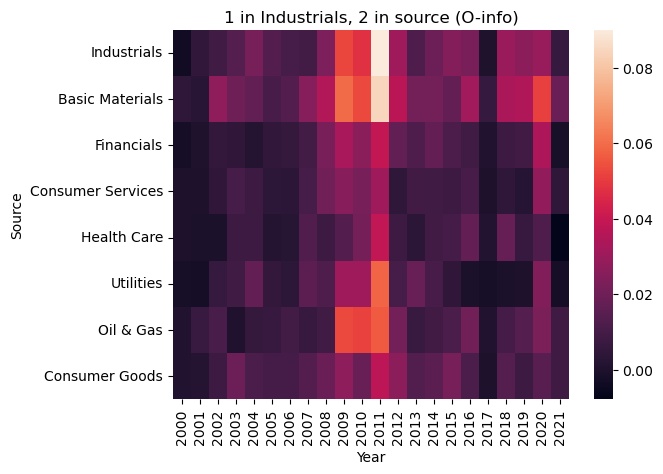

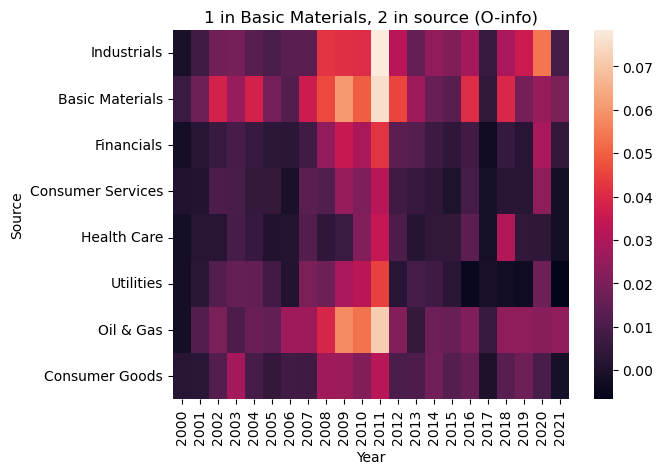

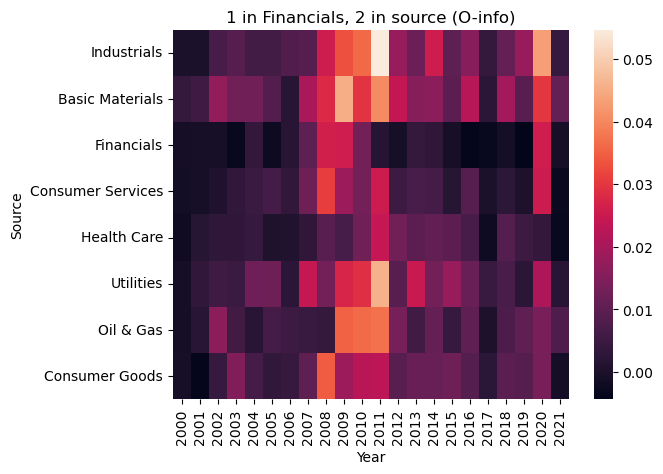

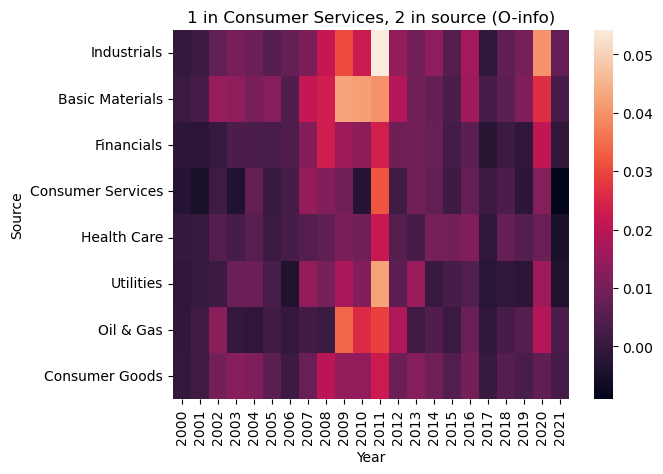

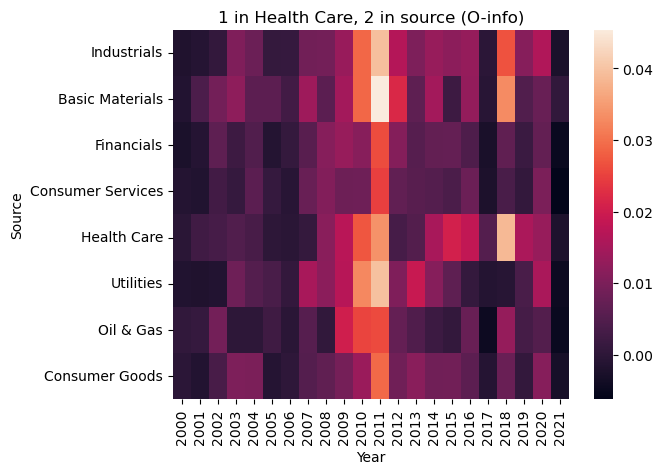

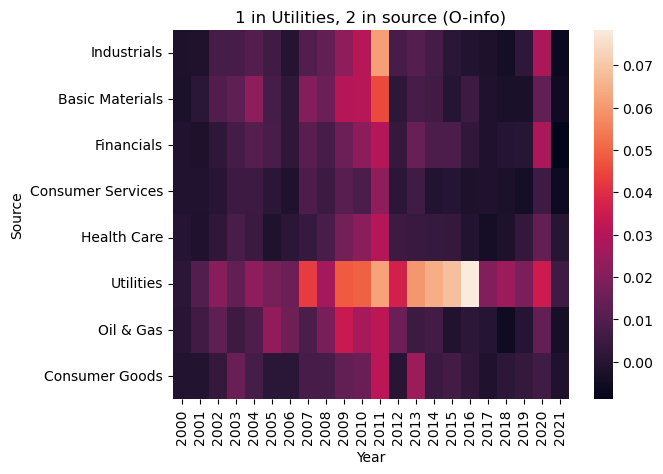

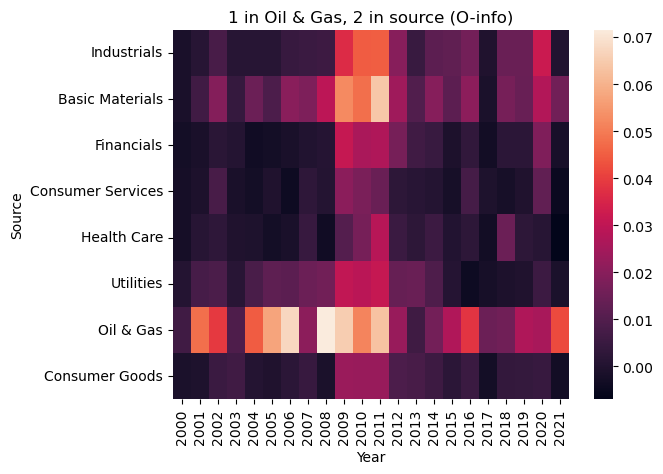

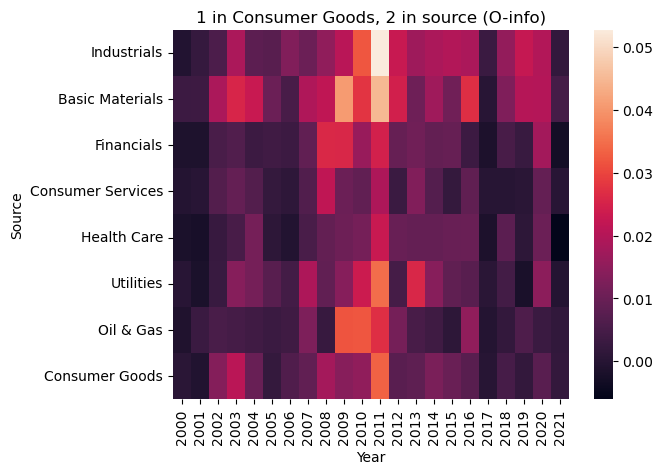

In [51]:
# DO NOT RUN IF YOU ALREADY HAVE THE HEATMAPS

for sector in sectors:
    sns.heatmap(df_one_year_all_sectors[sector])

    plt.xlabel("Year")
    plt.ylabel("Source")
    plt.title(f"1 in {sector}, 2 in source (O-info)")

    plt.savefig(
        f"./results/economic_results/comparison/o_info/images/heatmap_one_year_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

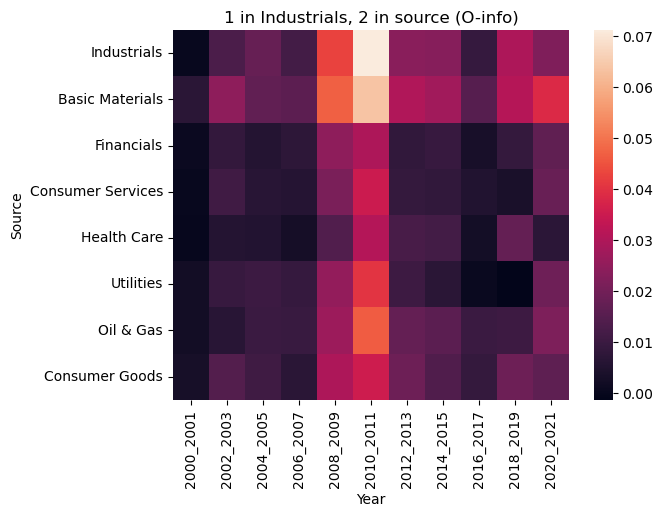

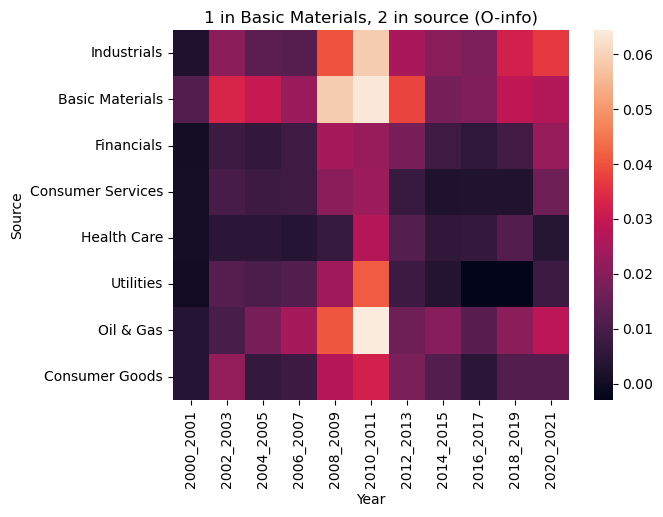

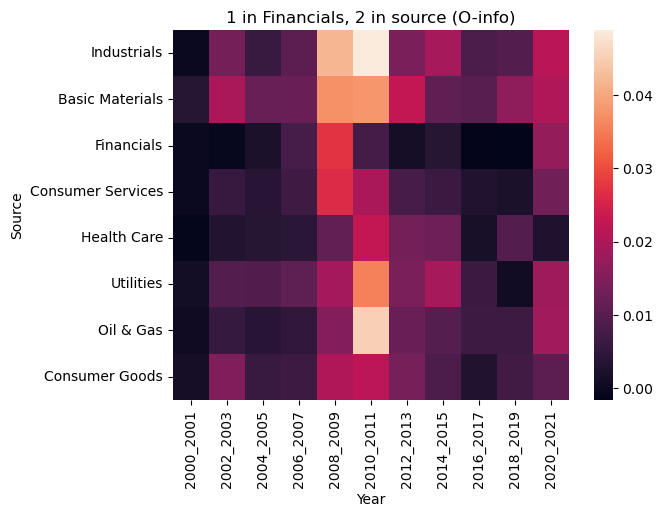

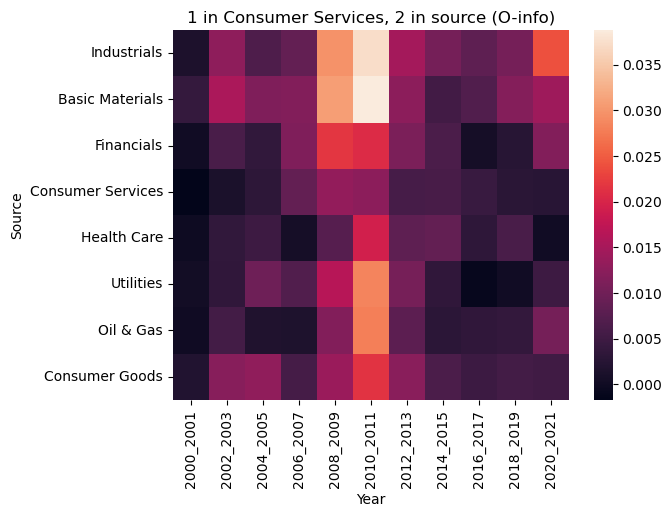

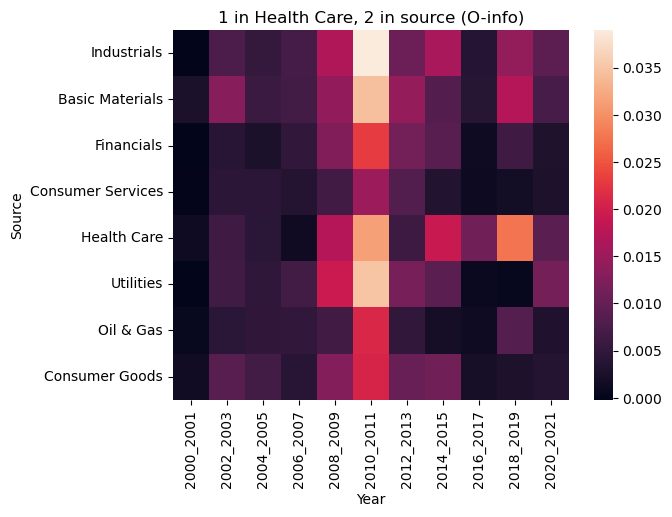

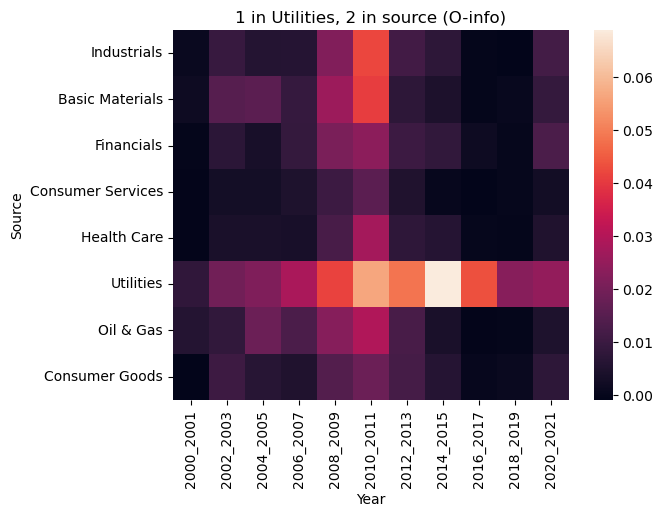

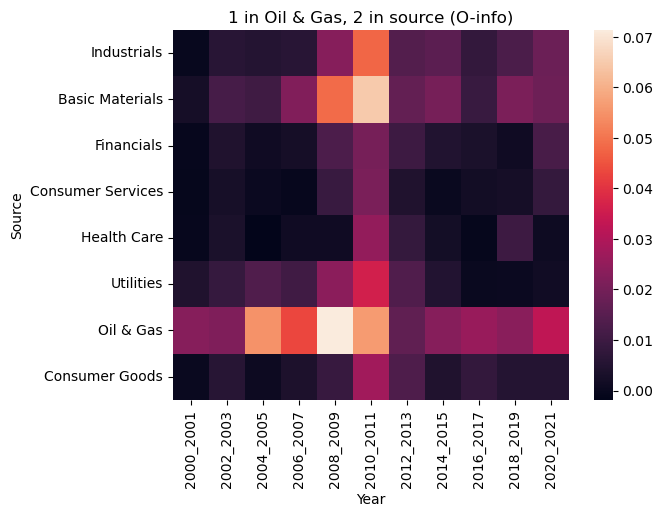

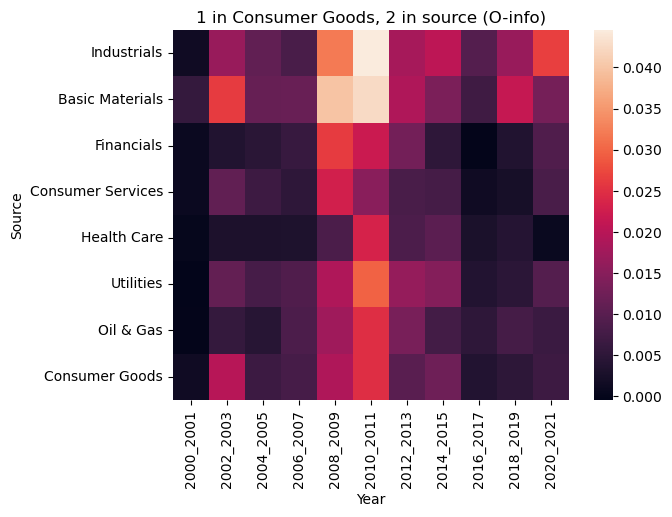

In [52]:
# DO NOT RUN IF YOU ALREADY HAVE THE HEATMAPS

for sector in sectors:
    sns.heatmap(df_two_years_all_sectors[sector])

    plt.xlabel("Year")
    plt.ylabel("Source")
    plt.title(f"1 in {sector}, 2 in source (O-info)")

    plt.savefig(
        f"./results/economic_results/comparison/o_info/images/heatmap_two_years_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

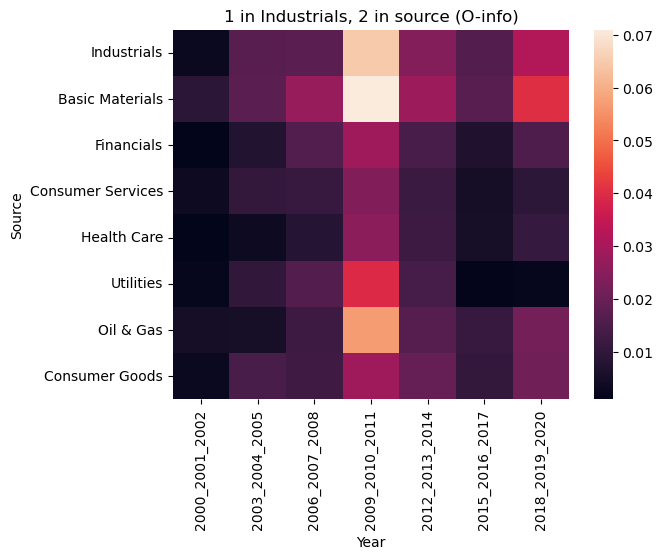

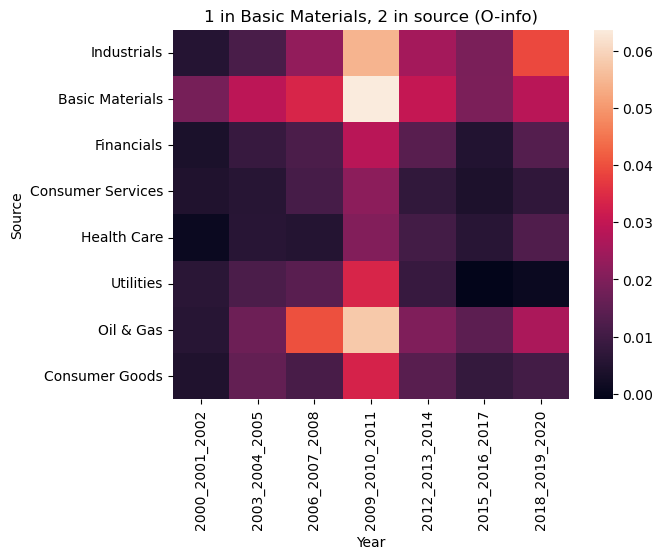

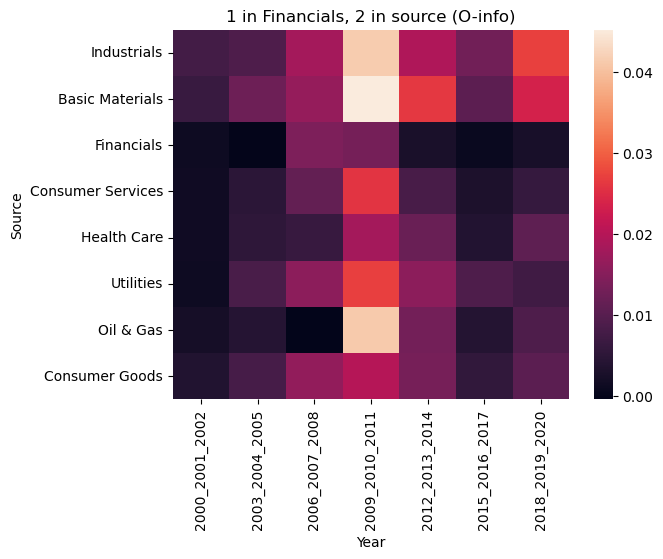

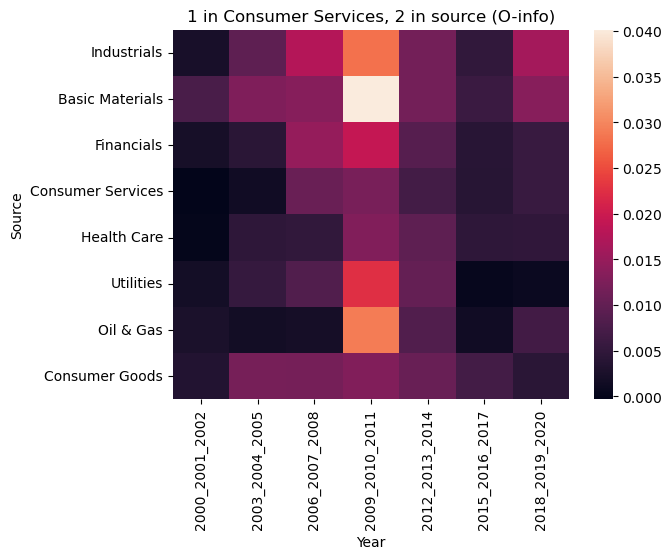

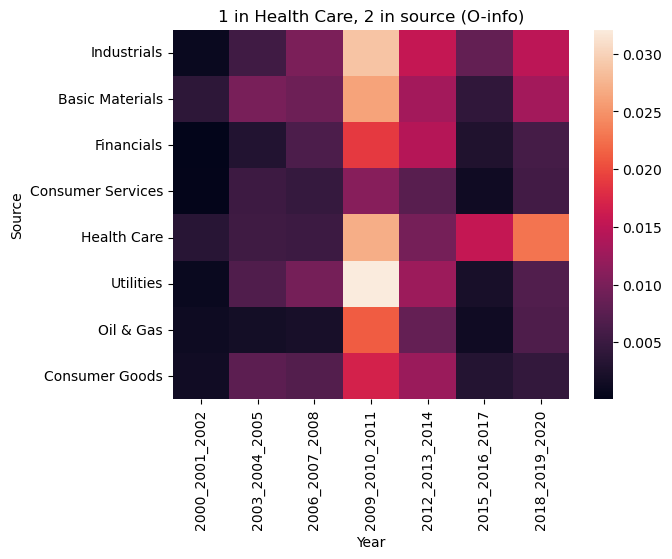

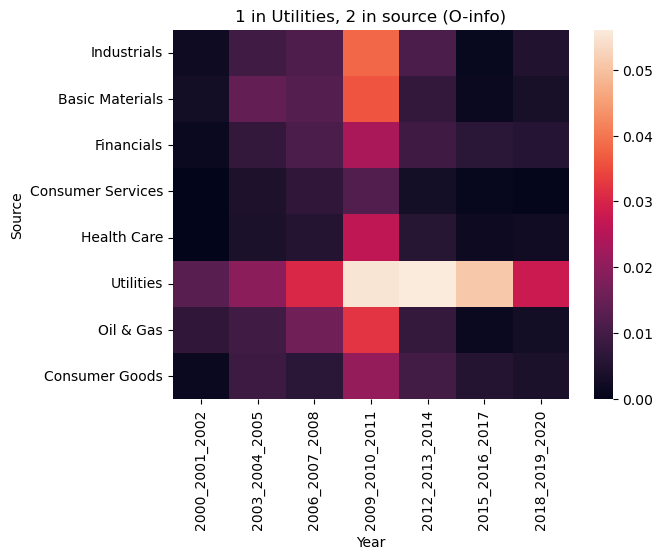

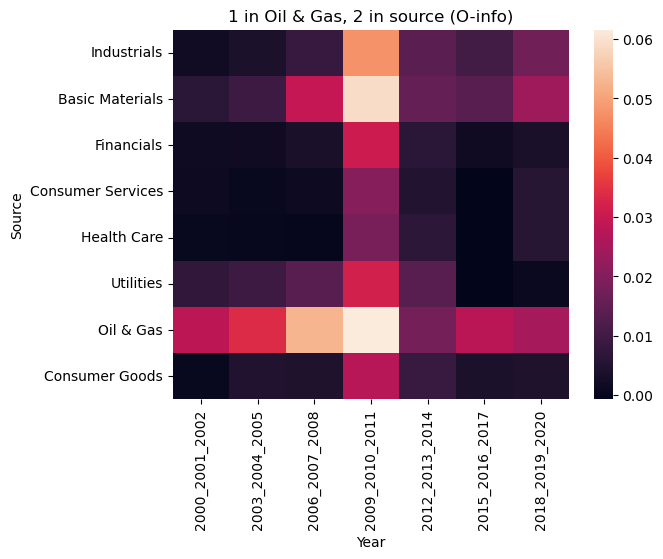

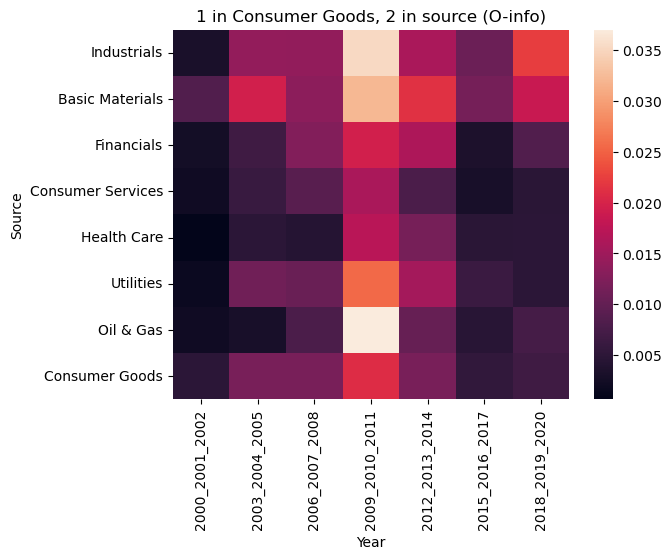

In [53]:
# DO NOT RUN IF YOU ALREADY HAVE THE HEATMAPS

for sector in sectors:
    sns.heatmap(df_three_years_all_sectors[sector])

    plt.xlabel("Year")
    plt.ylabel("Source")
    plt.title(f"1 in {sector}, 2 in source (O-info)")

    plt.savefig(
        f"./results/economic_results/comparison/o_info/images/heatmap_three_years_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()